<a href="https://colab.research.google.com/github/sgirabin/iti110projects/blob/main/ITI110_Project_IsakRabin_4466624P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-Requisite

## Dependencies Installation

In [ ]:
!pip install mlflow pyngrok tensorflow-text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.7/648.7 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.7 MB/s eta 0:00:00


# Implementation

## Libraries Imports

In [ ]:
# Standard library imports
import os
import getpass
import requests
import subprocess
import time
import zipfile
from collections import Counter
from datetime import datetime

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from mlflow.tracking import MlflowClient
from pyngrok import ngrok, conf
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve,
    confusion_matrix, precision_score, recall_score, f1_score
)

# TensorFlow/Keras imports
import tensorflow as tf
import tensorflow_text as tf_text
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Conv1D, BatchNormalization, MaxPooling1D,
    Dense, Flatten, Dropout, LSTM, SimpleRNN, TextVectorization,
    GRU, Bidirectional
)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Google Colab imports
from google.colab import drive

## Common Variables Declarations

### Google Drive

In [ ]:
# Google Drive Base Path
GOOGLE_DRIVE_BASE_PATH = "/content/drive/MyDrive/NYP/ITI110/Projects"

### Enron Spam Dataset

In [ ]:
# Enron Spam Dataset
ENRON_DOWNLOAD_URL = 'https://github.com/MWiechmann/enron_spam_data/blob/master/enron_spam_data.zip?raw=true'
ENRON_ZIP_FILE_PATH = os.path.join(GOOGLE_DRIVE_BASE_PATH, "Dataset/enron_spam_data.zip")
ENRON_CSV_FILE_PATH = os.path.join(GOOGLE_DRIVE_BASE_PATH, "Dataset/enron_spam_data.csv")

### GloVe Embeddings

In [ ]:
# GloVe embeddings
GLOVE_DOWNLOAD_URL = 'http://nlp.stanford.edu/data/glove.6B.zip'
GLOVE_ZIP_FILE_PATH = os.path.join(GOOGLE_DRIVE_BASE_PATH, "Embeddings/glove.6B.zip")
GLOVE_TXT_FILE_PATH = os.path.join(GOOGLE_DRIVE_BASE_PATH, "Embeddings/glove.6B.100d.txt")

### MLFlow

In [ ]:
# MLFlow Logging Directory
MLFLOW_LOG_DIR = os.path.join(GOOGLE_DRIVE_BASE_PATH, "Logs/")

### Model Save Directory

In [ ]:
# Model Directory
MODELS_SAVE_PATH = os.path.join(GOOGLE_DRIVE_BASE_PATH, "Models/")

### Constant Variables

In [ ]:
# Tokenizer and Padding
MAX_SEQUENCE_LENGTH = 500 # Padding to max length

# Embedding
EMBEDDING_DIM = 100 # Embedding Dimension

# Training Parameters
BATCH_SIZES = [16, 32, 64]
KERNEL_SIZE = [3, 5, 7]
DENSE = [[256, 128], [128, 64], [64, 32]]
LEARNING_RATES = [0.001, 0.0005, 0.0001]

## Function Declarations

### Function: Mount Google Drive

In [ ]:
# Mount Google Drive
def mount_google_drive():
    drive.mount('/content/drive')

### Function: Download and Extract Zip File

In [ ]:
# Download and extract dataset
def download_and_extract(file, zip_file,
                         download_url, target_dir=GOOGLE_DRIVE_BASE_PATH):
    if not os.path.exists(file):
        print(f"File {file} does not exist")
        if not os.path.exists(zip_file):
            print(f"File {zip_file} does not exist")
            print(f"Downloading dataset from {download_url}...")
            response = requests.get(download_url, stream=True)
            with open(zip_file, 'wb') as f:
                f.write(response.content)
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(target_dir)
        print(f"Dataset {zip_file} extracted successfully to {target_dir}!")

### Function: Pre-Processing Text (Email Content)

In [ ]:
# Preprocess text and handle missing values
def pre_process_texts(texts):
    # Convert all non-string entries to empty strings
    texts = texts.fillna("").astype(str)

    # Convert all string to lower case
    texts = texts.str.lower()

    # Replace punctuation, special symbolds
    texts = texts.str.replace(r'[^\w\s]', '', regex=True)

    # Replace \n character with space
    texts = texts.str.replace(r'\n', ' ', regex=True)

    # Replace number (0,1,2,3...9) to NUMBER
    texts = texts.str.replace(r'\d+', 'NUMBER', regex=True)

    # Replace url (http://xyz) to URL
    texts = texts.str.replace(r'http\S+|www\S+', 'URL', regex=True)
    return texts

### Function: Tokenize Email Content and apply Padding

In [ ]:
# Tokenization and padding
def tokenize_and_pad(texts, vocab_size, max_length):

    # Define the TextVectorization layer
    vectorize_layer = TextVectorization (
        max_tokens=vocab_size,
        output_mode="int",
        output_sequence_length=max_length
    )

    # Learn the vocabulary from the texts
    vectorize_layer.adapt(texts)

    # Convert texts into padded sequences
    padded = vectorize_layer(texts)

    return padded, vectorize_layer

### Function: Build CNN Model

In [ ]:
# Build CNN model
@mlflow.trace
def build_cnn(vocab_size, embedding_matrix, learning_rate=0.001,
              filters=256, kernel_size=5, pool_size=2,
              dense_units=[256, 128], dropout_rate=0.5, trainable=False,
              optimizer_type="adam"):

    model = Sequential([
        # Pre-trained GloVe Embedding Layer (now configurable)
        Embedding(vocab_size, EMBEDDING_DIM,
                  weights=[embedding_matrix], trainable=trainable),

        # Convolutional Layer (configurable filters & kernel size)
        #Conv1D(filters=filters, kernel_size=kernel_size, activation='relu',
        #       kernel_regularizer=l2(0.01)),
        #BatchNormalization(),
        #MaxPooling1D(pool_size=pool_size),

        # Flatten to prepare for dense layers
        #Flatten(),

        # Fully Connected Layers (configurable dense units & dropout)
        Dense(dense_units[0], activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(dropout_rate),
        Dense(dense_units[1], activation='relu'),
        Dropout(dropout_rate),

        # Output Layer for Binary Classification
        Dense(1, activation='sigmoid')
    ])

    # Configurable Optimizer
    optimizers = {
        "adam": Adam(learning_rate=learning_rate),
        "rmsprop": RMSprop(learning_rate=learning_rate),
        "sgd": SGD(learning_rate=learning_rate)
    }
    model.compile(optimizer=optimizers[optimizer_type],
                  loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()
    return model

### Function: Build CNN + LTSM Model

In [ ]:
# Model for Hybrid CNN + LSTM
@mlflow.trace
def build_cnn_ltsm(vocab_size, embedding_matrix, learning_rate=0.001,
              filters=128, kernel_size=5, pool_size=2,
              dense_units=[128, 64], dropout_rate=0.5, trainable=False,
              optimizer_type="adam"):

    model = Sequential([
        # Pre-trained GloVe Embedding Layer (now configurable)
        Embedding(vocab_size, EMBEDDING_DIM,
                  weights=[embedding_matrix], trainable=trainable),

        # Convolutional Layer (configurable filters & kernel size)
        #Conv1D(filters=filters, kernel_size=kernel_size, activation='relu',
        #       padding = 'same'),
        #BatchNormalization(),
        #MaxPooling1D(pool_size=pool_size),

        # Replace two LSTMs with a single Bidirectional LSTM
        Bidirectional(LSTM(128, return_sequences=False)),

        # Fully Connected Layers (configurable dense units & dropout)
        Dense(dense_units[0], activation='relu'),
        Dropout(dropout_rate),
        Dense(dense_units[1], activation='relu'),
        Dropout(dropout_rate),

        # Output Layer for Binary Classification
        Dense(1, activation='sigmoid')
    ])

    # Configurable Optimizer
    optimizers = {
        "adam": Adam(learning_rate=learning_rate),
        "rmsprop": RMSprop(learning_rate=learning_rate),
        "sgd": SGD(learning_rate=learning_rate)
    }
    model.compile(optimizer=optimizers[optimizer_type],
                  loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()
    return model

### Function: Build RNN + LTSM Model

In [ ]:
# Model for RNN + LSTM
@mlflow.trace
def build_rnn_lstm(vocab_size, embedding_matrix, learning_rate=0.001,
              dense_units=[128, 64], dropout_rate=0.5, trainable=False,
              optimizer_type="adam"):
    model = Sequential([
        # Pre-trained GloVe Embedding Layer (now configurable)
        Embedding(vocab_size, EMBEDDING_DIM,
                  weights=[embedding_matrix], trainable=trainable),

        # GRU
        GRU(128, return_sequences=True),

        # Replace two LSTMs with a single Bidirectional LSTM
        #Bidirectional(LSTM(128, return_sequences=False)),

        # Fully Connected Layers (configurable dense units & dropout)
        Dense(dense_units[0], activation='relu'),
        Dropout(dropout_rate),
        Dense(dense_units[1], activation='relu'),
        Dropout(dropout_rate),

        # Output Layer for Binary Classification
        Dense(1, activation='sigmoid')
    ])

    # Configurable Optimizer
    optimizers = {
        "adam": Adam(learning_rate=learning_rate),
        "rmsprop": RMSprop(learning_rate=learning_rate),
        "sgd": SGD(learning_rate=learning_rate)
    }
    model.compile(optimizer=optimizers[optimizer_type],
                  loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()
    return model

### Function: Model Training and Evaluation

In [ ]:
# Train and Evaluate Model
@mlflow.trace
def train_and_evaluate(model, model_name, lr,
                       X_train, y_train, X_val, y_val, X_test, y_test):

    for batch_size in BATCH_SIZES:

      timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
      experiment_name = f"EnronSpam_{model_name}_{timestamp}_LR_{lr}_Batch_{batch_size}"

      mlflow.set_experiment(experiment_name=f"{model_name} with LR {lr} and Batch {batch_size}")

      with mlflow.start_run():
          mlflow.log_param("batch_size", batch_size)
          mlflow.log_param("learning_rate", lr)

          early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                                         restore_best_weights=True)

          history = model.fit(X_train, y_train,
                              validation_data=(X_val, y_val),
                              epochs=50,
                              batch_size=batch_size,
                              callbacks=[early_stopping])

          # Log metrics
          for epoch, logs in enumerate(history.history['accuracy']):
              mlflow.log_metric("train_accuracy", logs, step=epoch)
          for epoch, logs in enumerate(history.history['val_accuracy']):
              mlflow.log_metric("val_accuracy", logs, step=epoch)
          for epoch, logs in enumerate(history.history['loss']):
              mlflow.log_metric("loss", logs, step=epoch)
          for epoch, logs in enumerate(history.history['val_loss']):
              mlflow.log_metric("val_loss", logs, step=epoch)


          # Evaluate and log loss, accuracy, and predictions
          test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
          predictions = (model.predict(X_test) > 0.5).astype(int)

          precision = precision_score(y_test, predictions)
          recall = recall_score(y_test, predictions)
          f1 = f1_score(y_test, predictions)
          roc_auc = roc_auc_score(y_test, model.predict(X_test))


          mlflow.log_metric("test_loss", test_loss)
          mlflow.log_metric("test_accuracy", test_accuracy)
          mlflow.log_metric("precision", precision)
          mlflow.log_metric("recall", recall)
          mlflow.log_metric("f1_score", f1)
          mlflow.log_metric("roc_auc", roc_auc)

          print(f"test_loss: {test_loss}")
          print(f"test_accuracy: {test_accuracy}")
          print(f"precision: {precision}")
          print(f"recall: {recall}")
          print(f"f1_score: {f1}")
          print(f"roc_auc: {roc_auc}")

          # Save the model
          model_filename = f"{model_name}_{timestamp}_LR_{lr}_Batch_{batch_size}_{test_accuracy:.4f}"
          model_path = os.path.join(GOOGLE_DRIVE_BASE_PATH, f"Models/{model_filename}.keras")
          model.save(model_path)
          mlflow.log_artifact(model_path)

          print(f"{model_name} - Test Accuracy: {test_accuracy:.4f}, ROC AUC: {roc_auc:.4f}")

          # Confusion Matrix
          cm = confusion_matrix(y_test, predictions)
          sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
          plt.xlabel('Predicted')
          plt.ylabel('Actual')
          plt.title(f'Confusion Matrix - {model_name}')
          plt.show()

          # Accuracy
          plt.plot(history.history['accuracy'], label='Train Accuracy')
          plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
          plt.xlabel('Epochs')
          plt.ylabel('Accuracy')
          plt.legend()
          plt.title(f'{model_name} - Training & Validation Accuracy')
          plt.show()

          # Loss
          plt.plot(history.history['loss'], label='Train Loss')
          plt.plot(history.history['val_loss'], label='Validation Loss')
          plt.xlabel('Epochs')
          plt.ylabel('Loss')
          plt.legend()
          plt.title(f'{model_name} - Training & Validation Loss')
          plt.show()

          # Plot ROC Curve
          fpr, tpr, _ = roc_curve(y_test, predictions)
          plt.figure()
          plt.plot(fpr, tpr, color='blue', label=f"AUC = {roc_auc_score(y_test, predictions):.4f}")
          plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
          plt.title(f'{model_name} - ROC Curve')
          plt.xlabel("False Positive Rate")
          plt.ylabel("True Positive Rate")
          plt.legend()
          plt.show()

# Experiments

## Preparations

### Mount Google Drive

In [ ]:
# Mount Google Drive
mount_google_drive()

Mounted at /content/drive


### Check Enron Spam Dataset

In [ ]:
# Download Enron Spam Dataset if does not exist
enron_target_path = os.path.join(GOOGLE_DRIVE_BASE_PATH, "Dataset/")
download_and_extract(ENRON_CSV_FILE_PATH, ENRON_ZIP_FILE_PATH, ENRON_DOWNLOAD_URL, enron_target_path)

# Read Enron Spam Dataset
data = pd.read_csv(ENRON_CSV_FILE_PATH)

# Display Total Records of Enron Spam Dataset
print(f"Total records: {data.shape[0]}")

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(data.head())

Total records: 33716
First few rows of the dataset:
   Message ID                       Subject  \
0           0  christmas tree farm pictures   
1           1      vastar resources , inc .   
2           2  calpine daily gas nomination   
3           3                    re : issue   
4           4     meter 7268 nov allocation   

                                             Message Spam/Ham        Date  
0                                                NaN      ham  1999-12-10  
1  gary , production from the high island larger ...      ham  1999-12-13  
2             - calpine daily gas nomination 1 . doc      ham  1999-12-14  
3  fyi - see note below - already done .\nstella\...      ham  1999-12-14  
4  fyi .\n- - - - - - - - - - - - - - - - - - - -...      ham  1999-12-14  


### Data Cleaning: Remove unused features

In [ ]:
# Remove Unecessary Column
data = data.drop(columns=['Message ID', 'Subject', 'Date'])

### Data Cleaning: Preprocessed Email Content

In [ ]:
# Preprocess Enron Spam dataset
print(data['Message'])
data['Message'] = pre_process_texts(data['Message'])
print(data['Message'])

0                                                      NaN
1        gary , production from the high island larger ...
2                   - calpine daily gas nomination 1 . doc
3        fyi - see note below - already done .\nstella\...
4        fyi .\n- - - - - - - - - - - - - - - - - - - -...
                               ...                        
33711    hello , welcome to gigapharm onlinne shop .\np...
33712    i got it earlier than expected and it was wrap...
33713    are you ready to rock on ? let the man in you ...
33714    learn how to last 5 - 10 times longer in\nbed ...
33715    hi : )\ndo you need some softwares ? i can giv...
Name: Message, Length: 33716, dtype: object
0                                                         
1        gary  production from the high island larger b...
2                 calpine daily gas nomination NUMBER  doc
3        fyi  see note below  already done  stella     ...
4        fyi                        forwarded by lauri ...
            

### Data Cleaning: Convert Categorical Data to Numeric

In [ ]:
# Convert Categorical to Numeric for Training
data['Spam/Ham'] = data['Spam/Ham'].apply(lambda x: 1 if x == 'spam' else 0)

### Confirming Dataset

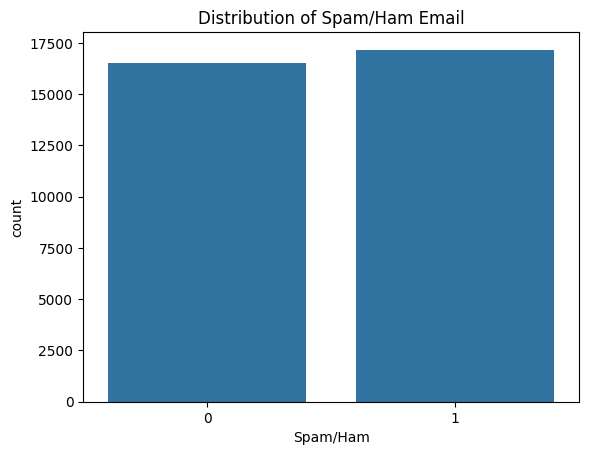

In [ ]:
# Check the distribution of Enron Spam Dataset
sns.countplot(x='Spam/Ham', data=data)
plt.title('Distribution of Spam/Ham Email')
plt.show()

### Data Splitting: Training (70%), Validation (15%), Testing (15%)

In [ ]:
X = data['Message']
y = data['Spam/Ham']

In [ ]:
# Split data: Training (70%), Validation (15%), Testing (15%).
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
print(f" Training data size = {X_train.shape}")
print(f" Training data size = {X_val.shape}")
print(f" Training data size = {X_test.shape}")

 Training data size = (23601,)
 Training data size = (5057,)
 Training data size = (5058,)


### Tokenise

In [ ]:
# Count words in the dataset
word_counts = Counter(" ".join(X_train).split())

# Print total unique words
total_unique_words = len(word_counts)
print(f"Total Unique Words in Dataset: {total_unique_words}")

Total Unique Words in Dataset: 120646


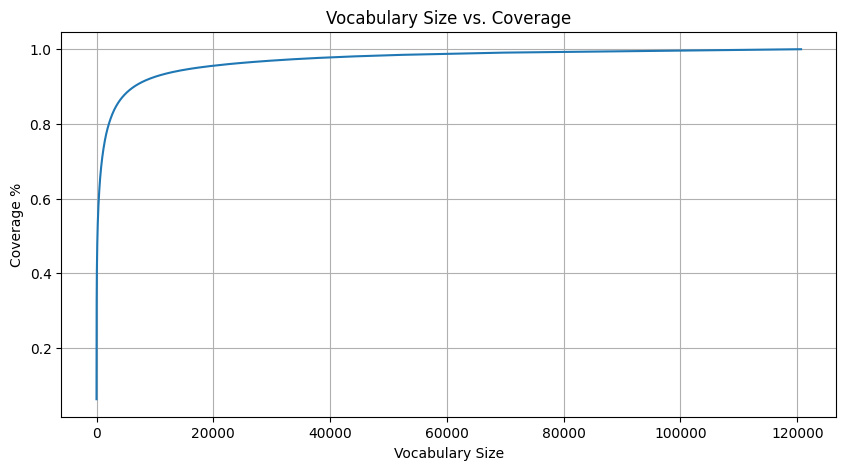

Recommended VOCAB_SIZE for 95% coverage: 17093


In [ ]:
# Get word frequencies sorted in descending order
word_frequencies = np.array(sorted(word_counts.values(), reverse=True))

# Compute cumulative percentage coverage
cumulative_coverage = np.cumsum(word_frequencies) / np.sum(word_frequencies)

# Plot cumulative distribution of vocabulary size
plt.figure(figsize=(10, 5))
plt.plot(cumulative_coverage)
plt.xlabel("Vocabulary Size")
plt.ylabel("Coverage %")
plt.title("Vocabulary Size vs. Coverage")
plt.grid()
plt.show()

# Find vocab size covering 95% of words
optimal_vocab_size = np.argmax(cumulative_coverage >= 0.95) + 1
print(f"Recommended VOCAB_SIZE for 95% coverage: {optimal_vocab_size}")

Max Length: 37136
Average Length: 236.56
95th Percentile: 744.0
99th Percentile: 1543.0


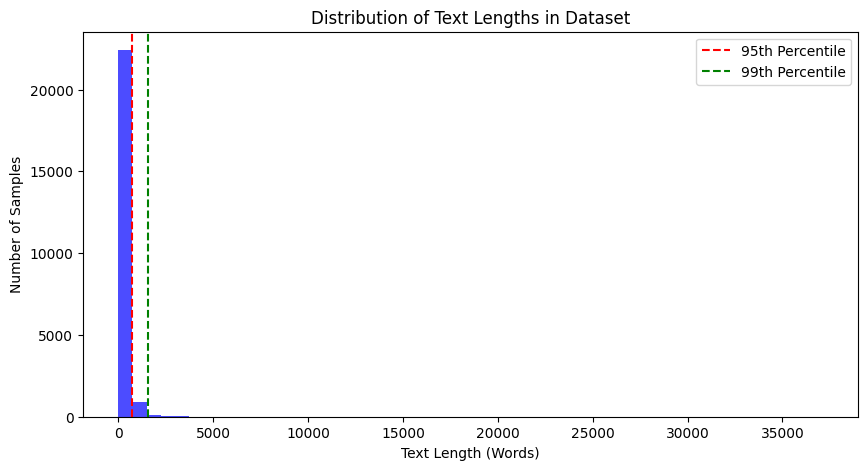

In [ ]:
# Compute text lengths
text_lengths = X_train.apply(lambda x: len(x.split()))  # Count words in each sample

# Print basic statistics
max_length = np.max(text_lengths)
avg_length = np.mean(text_lengths)
percentile05_length = np.percentile(text_lengths, 95)
percentile09_length = np.percentile(text_lengths, 99)

print(f"Max Length: {max_length}")
print(f"Average Length: {avg_length:.2f}")
print(f"95th Percentile: {percentile05_length}")
print(f"99th Percentile: {percentile09_length}")

# Plot text length distribution
plt.figure(figsize=(10, 5))
plt.hist(text_lengths, bins=50, color='blue', alpha=0.7)
plt.axvline(np.percentile(text_lengths, 95), color='red', linestyle='--', label="95th Percentile")
plt.axvline(np.percentile(text_lengths, 99), color='green', linestyle='--', label="99th Percentile")
plt.xlabel("Text Length (Words)")
plt.ylabel("Number of Samples")
plt.title("Distribution of Text Lengths in Dataset")
plt.legend()
plt.show()

In [ ]:
# Tokenize and pad
X_train_padded, vectorize_layer = tokenize_and_pad(X_train,
                                                   vocab_size=optimal_vocab_size,
                                                   max_length=int(percentile05_length))
X_val_padded = vectorize_layer(X_val)
X_test_padded = vectorize_layer(X_test)

### Prepare Embeddings

In [ ]:
# Download GloVe embeddings, extract if not already downloaded
glove_target_path = os.path.join(GOOGLE_DRIVE_BASE_PATH, "Embeddings/")
download_and_extract(GLOVE_TXT_FILE_PATH, GLOVE_ZIP_FILE_PATH, GLOVE_DOWNLOAD_URL, glove_target_path)

In [ ]:
# Initialize the embedding matrix
vocab = vectorize_layer.get_vocabulary()
print(vectorize_layer)

word_index = {word: i for i, word in enumerate(vocab)}
print(f"Vocabulary Size: {len(word_index)}")

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
print(f"Embedding Matrix Shape: {embedding_matrix.shape}")

# Load GloVe embeddings
print("Loading GloVe Word Embedding...")
with open(GLOVE_TXT_FILE_PATH, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        if word in word_index:
            embedding_matrix[word_index[word]] = coefs

print(f"GloVe embeddings loaded. Matrix size: {embedding_matrix.shape}")


<TextVectorization name=text_vectorization, built=True>
Vocabulary Size: 17093
Embedding Matrix Shape: (17094, 100)
Loading GloVe Word Embedding...
GloVe embeddings loaded. Matrix size: (17094, 100)


## Model Training

### Tracking the Experiment

In [ ]:
# Kill existing process if any
! pkill -f ngrok

In [ ]:
# Start the MLflow UI
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", "file://" + MLFLOW_LOG_DIR])

<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', 'file...>

In [ ]:
# Set MLflow Tracking URI
mlflow.set_tracking_uri("file://" + MLFLOW_LOG_DIR)
conf.get_default().auth_token = "2t8TIG1geBuF6yFcNXZYkkxTqzg_7qGykBf4NYA9AKwvB9u8R"
port=5000
public_url = ngrok.connect(port).public_url

### CNN

2025/02/24 01:57:15 WARNING mlflow.tracing.processor.mlflow: Creating a trace within the default experiment with id '0'. It is strongly recommended to not use the default experiment to log traces due to ambiguous search results and probable performance issues over time due to directory table listing performance degradation with high volumes of directories within a specific path. To avoid performance and disambiguation issues, set the experiment for your environment using `mlflow.set_experiment()` API.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       1,709,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,709,400 (6.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,709,400 (6.52 MB)

2025/02/24 01:57:18 INFO mlflow.tracking.fluent: Experiment with name 'cnn with LR 0.001 and Batch 16' does not exist. Creating a new experiment.


Epoch 1/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 35s 16ms/step - accuracy: 0.7971 - loss: 8.4365 - val_accuracy: 0.9577 - val_loss: 1.7436
Epoch 2/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9445 - loss: 1.5408 - val_accuracy: 0.9027 - val_loss: 1.5243
Epoch 3/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9516 - loss: 0.9997 - val_accuracy: 0.9474 - val_loss: 1.0269
Epoch 4/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9572 - loss: 0.7891 - val_accuracy: 0.9622 - val_loss: 0.7142
Epoch 5/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9573 - loss: 0.7114 - val_accuracy: 0.9080 - val_loss: 0.6784
Epoch 6/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9549 - loss: 0.6580 - val_accuracy: 0.8956 - val_loss: 0.7891
Epoch 7/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9556 - loss: 0.6241 - val_accuracy: 0.9565 - val_loss: 0.5833
Epoch 8/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9589 -

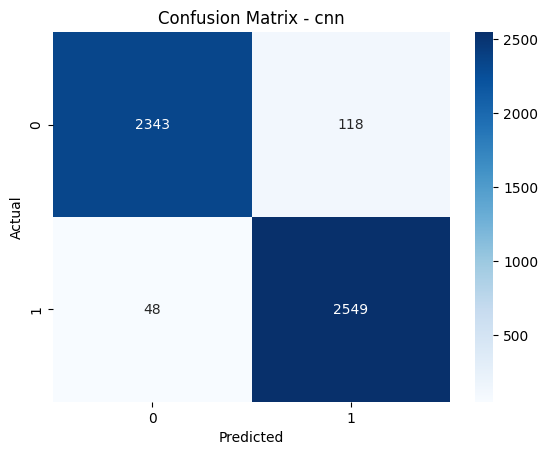

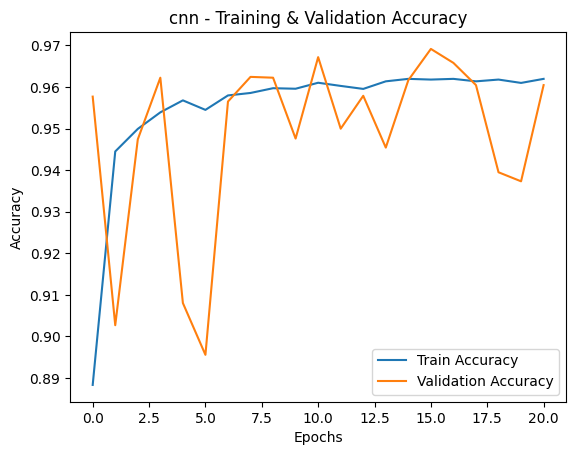

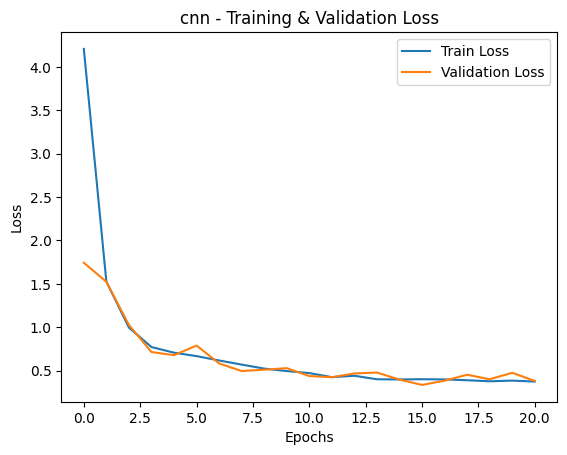

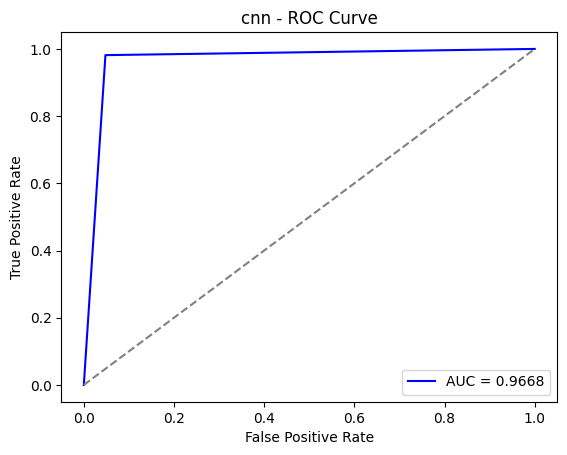

2025/02/24 02:05:12 INFO mlflow.tracking.fluent: Experiment with name 'cnn with LR 0.001 and Batch 32' does not exist. Creating a new experiment.


Epoch 1/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.9704 - loss: 0.3141 - val_accuracy: 0.9652 - val_loss: 0.2970
Epoch 2/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9745 - loss: 0.2723 - val_accuracy: 0.9559 - val_loss: 0.3351
Epoch 3/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.9723 - loss: 0.2887 - val_accuracy: 0.9644 - val_loss: 0.3024
Epoch 4/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.9725 - loss: 0.2897 - val_accuracy: 0.9697 - val_loss: 0.2727
Epoch 5/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.9727 - loss: 0.2778 - val_accuracy: 0.9674 - val_loss: 0.3014
Epoch 6/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9721 - loss: 0.2823 - val_accuracy: 0.9444 - val_loss: 0.3616
Epoch 7/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9729 - loss: 0.2830 - val_accuracy: 0.9699 - val_loss: 0.2953
Epoch 8/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.9744 - loss: 0.2634 - 

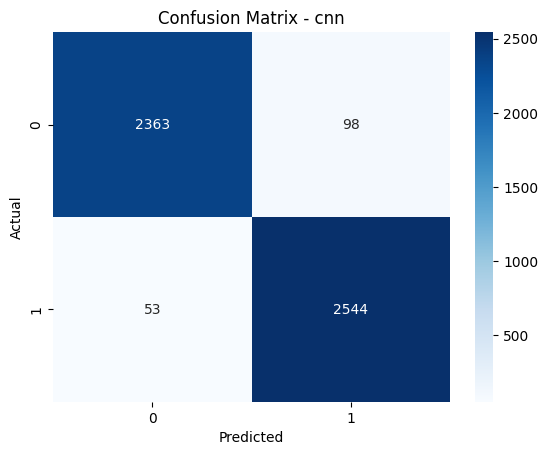

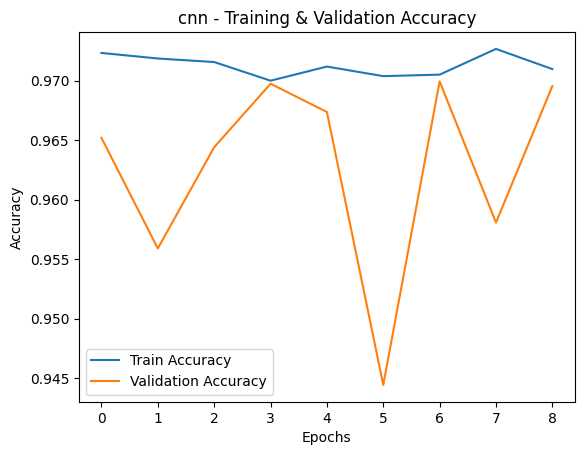

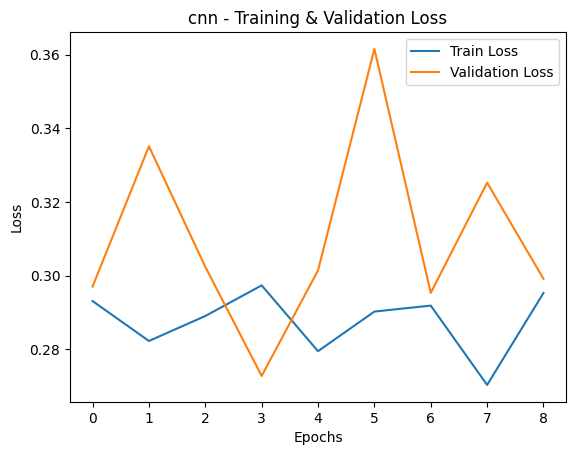

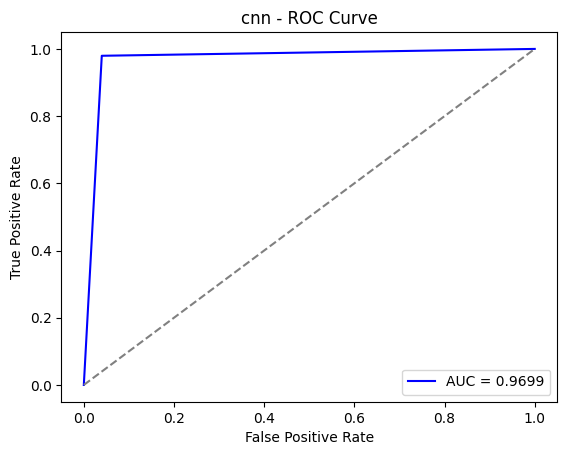

2025/02/24 02:08:08 INFO mlflow.tracking.fluent: Experiment with name 'cnn with LR 0.001 and Batch 64' does not exist. Creating a new experiment.


Epoch 1/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.9831 - loss: 0.2063 - val_accuracy: 0.9682 - val_loss: 0.2341
Epoch 2/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.9824 - loss: 0.1912 - val_accuracy: 0.9606 - val_loss: 0.2522
Epoch 3/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9822 - loss: 0.1873 - val_accuracy: 0.9656 - val_loss: 0.2656
Epoch 4/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9786 - loss: 0.2191 - val_accuracy: 0.9737 - val_loss: 0.2651
Epoch 5/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9821 - loss: 0.2021 - val_accuracy: 0.9733 - val_loss: 0.2012
Epoch 6/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.9777 - loss: 0.2149 - val_accuracy: 0.9608 - val_loss: 0.2734
Epoch 7/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9807 - loss: 0.2069 - val_accuracy: 0.9757 - val_loss: 0.2295
Epoch 8/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9812 - loss: 0.2116 - va

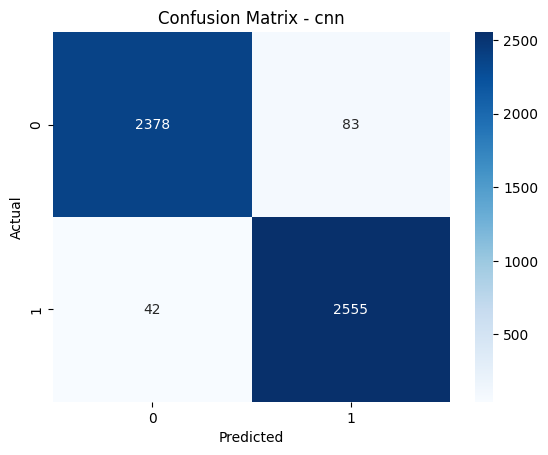

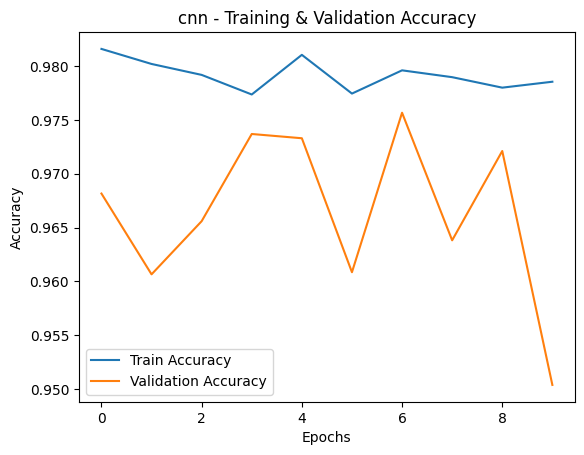

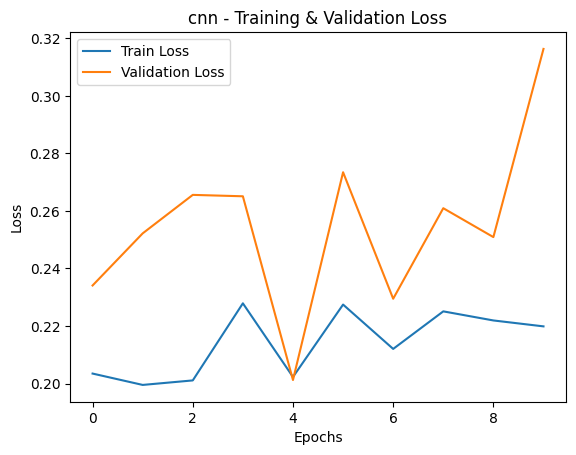

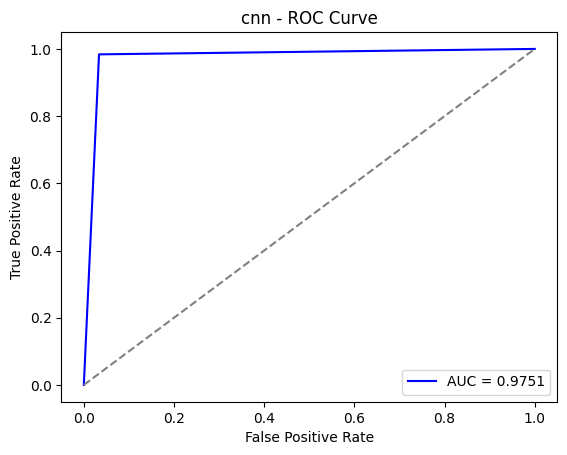

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       1,709,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,709,400 (6.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,709,400 (6.52 MB)

2025/02/24 02:10:04 INFO mlflow.tracking.fluent: Experiment with name 'cnn with LR 0.0005 and Batch 16' does not exist. Creating a new experiment.


Epoch 1/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - accuracy: 0.7829 - loss: 6.9065 - val_accuracy: 0.9474 - val_loss: 1.1333
Epoch 2/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - accuracy: 0.9553 - loss: 1.0240 - val_accuracy: 0.9630 - val_loss: 0.9588
Epoch 3/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.9607 - loss: 0.7769 - val_accuracy: 0.9703 - val_loss: 0.6846
Epoch 4/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9657 - loss: 0.7054 - val_accuracy: 0.9678 - val_loss: 0.7414
Epoch 5/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9661 - loss: 0.6628 - val_accuracy: 0.9430 - val_loss: 0.6236
Epoch 6/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9706 - loss: 0.5195 - val_accuracy: 0.9771 - val_loss: 0.4931
Epoch 7/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9733 - loss: 0.4914 - val_accuracy: 0.9662 - val_loss: 0.4399
Epoch 8/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9732 -

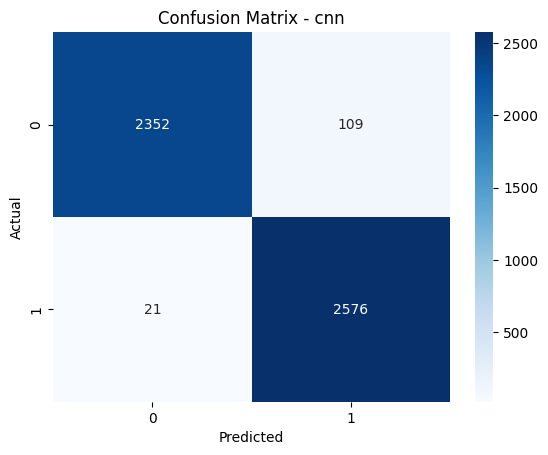

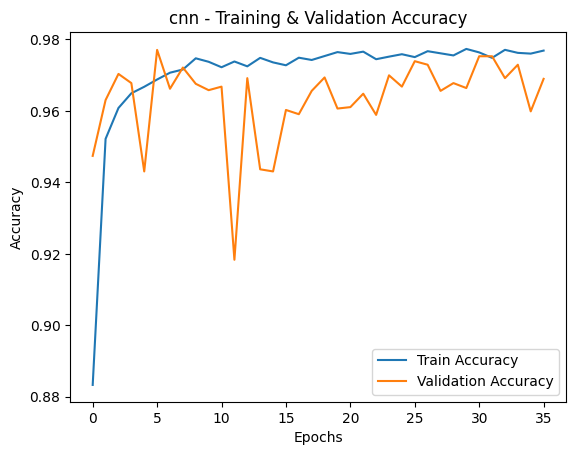

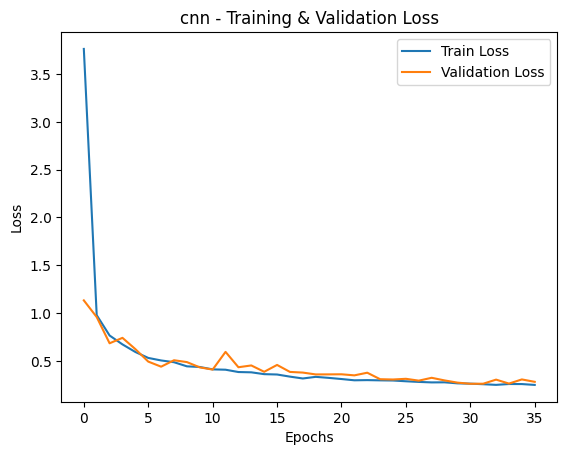

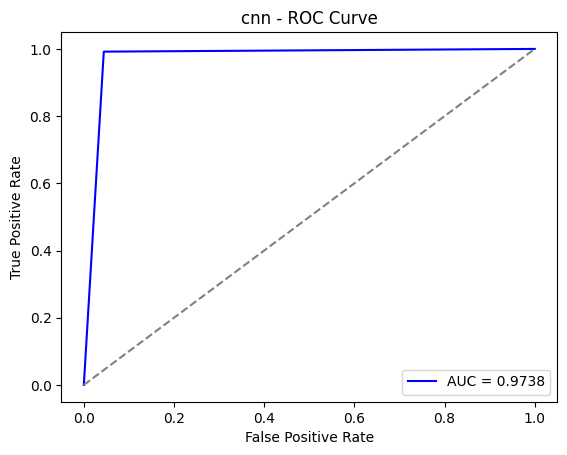

2025/02/24 02:26:41 INFO mlflow.tracking.fluent: Experiment with name 'cnn with LR 0.0005 and Batch 32' does not exist. Creating a new experiment.


Epoch 1/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9831 - loss: 0.2321 - val_accuracy: 0.9759 - val_loss: 0.2168
Epoch 2/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9874 - loss: 0.1702 - val_accuracy: 0.9690 - val_loss: 0.2377
Epoch 3/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.9824 - loss: 0.2001 - val_accuracy: 0.9729 - val_loss: 0.2405
Epoch 4/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9829 - loss: 0.1892 - val_accuracy: 0.9731 - val_loss: 0.2396
Epoch 5/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.9837 - loss: 0.1911 - val_accuracy: 0.9595 - val_loss: 0.2743
Epoch 6/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9849 - loss: 0.1842 - val_accuracy: 0.9729 - val_loss: 0.2385
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
test_loss: 0.21667753159999847
test_accuracy: 0.9778568744659424
precision: 0.9655301611090296
recall: 0.9922988063149788
f1_score: 0.9787

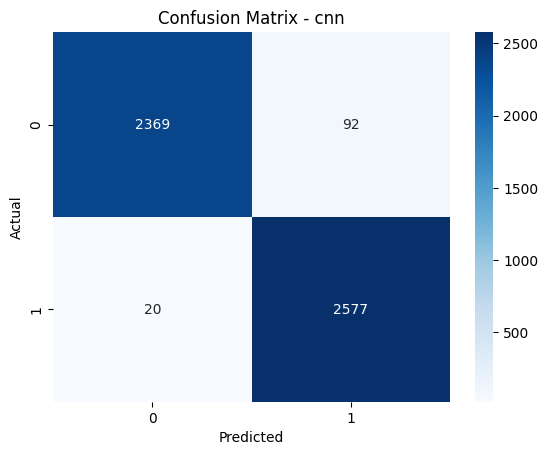

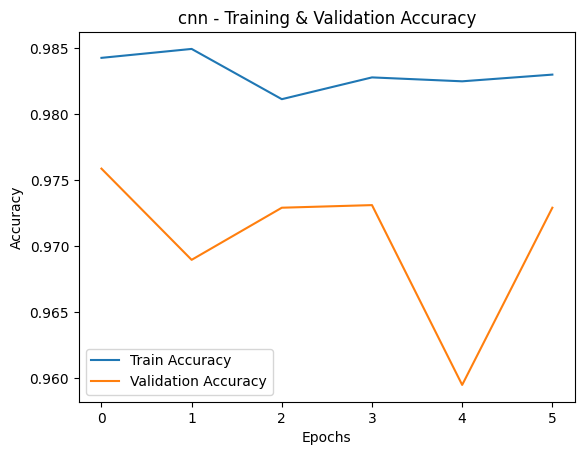

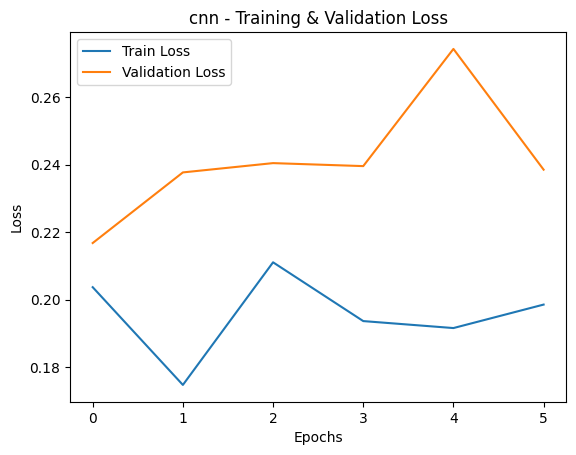

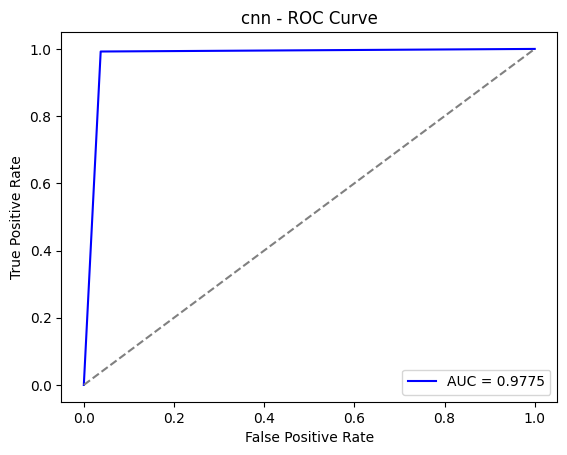

2025/02/24 02:28:34 INFO mlflow.tracking.fluent: Experiment with name 'cnn with LR 0.0005 and Batch 64' does not exist. Creating a new experiment.


Epoch 1/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.9913 - loss: 0.1496 - val_accuracy: 0.9796 - val_loss: 0.1666
Epoch 2/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9915 - loss: 0.1255 - val_accuracy: 0.9798 - val_loss: 0.1779
Epoch 3/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9901 - loss: 0.1396 - val_accuracy: 0.9794 - val_loss: 0.1966
Epoch 4/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9916 - loss: 0.1425 - val_accuracy: 0.9751 - val_loss: 0.2010
Epoch 5/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9909 - loss: 0.1403 - val_accuracy: 0.9773 - val_loss: 0.1852
Epoch 6/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9885 - loss: 0.1465 - val_accuracy: 0.9759 - val_loss: 0.2074
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
test_loss: 0.1617640107870102
test_accuracy: 0.9806247353553772
precision: 0.9767264402899657
recall: 0.9857527916827108
f1_score: 0.98121

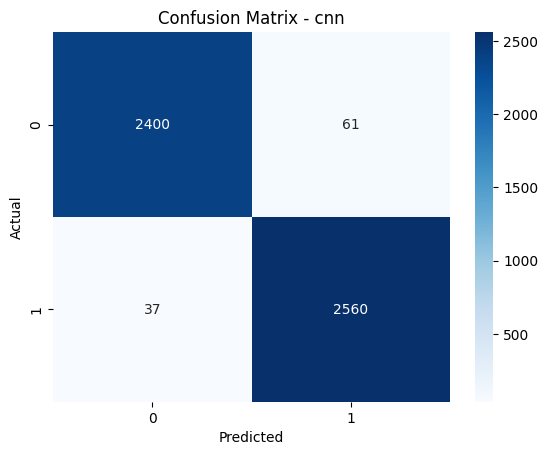

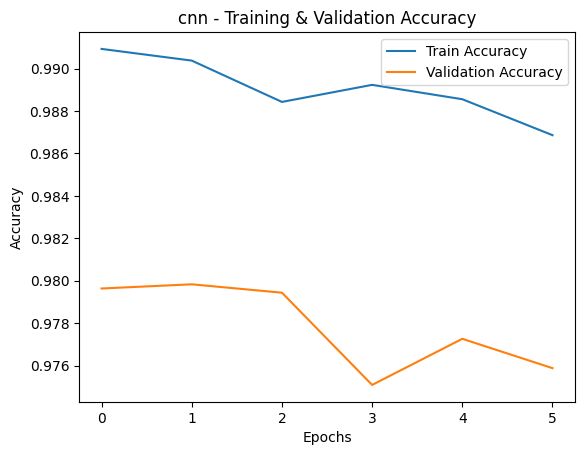

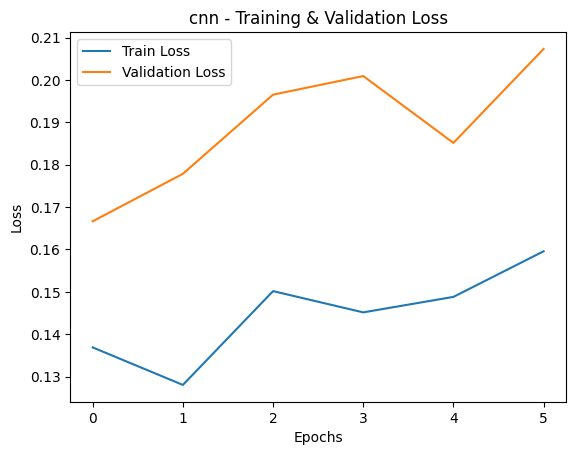

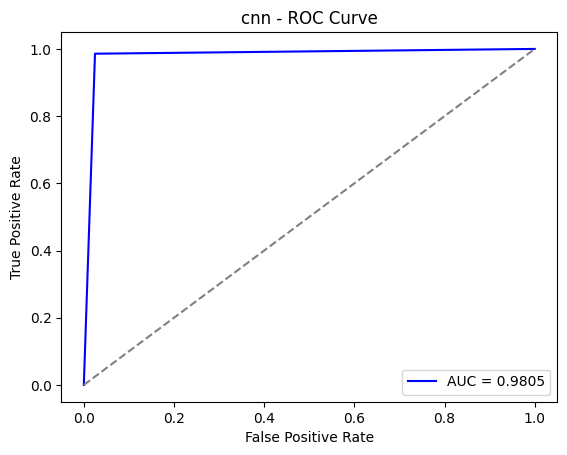

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │       1,709,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,709,400 (6.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,709,400 (6.52 MB)

2025/02/24 02:29:48 INFO mlflow.tracking.fluent: Experiment with name 'cnn with LR 0.0001 and Batch 16' does not exist. Creating a new experiment.


Epoch 1/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.6716 - loss: 7.4332 - val_accuracy: 0.9565 - val_loss: 3.6202
Epoch 2/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.9449 - loss: 3.0157 - val_accuracy: 0.9658 - val_loss: 1.6345
Epoch 3/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9697 - loss: 1.3994 - val_accuracy: 0.9670 - val_loss: 1.0620
Epoch 4/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9825 - loss: 0.8607 - val_accuracy: 0.9670 - val_loss: 0.7781
Epoch 5/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9849 - loss: 0.6295 - val_accuracy: 0.9729 - val_loss: 0.6744
Epoch 6/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9889 - loss: 0.5199 - val_accuracy: 0.9682 - val_loss: 0.5584
Epoch 7/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9864 - loss: 0.4450 - val_accuracy: 0.9608 - val_loss: 0.5209
Epoch 8/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9900 -

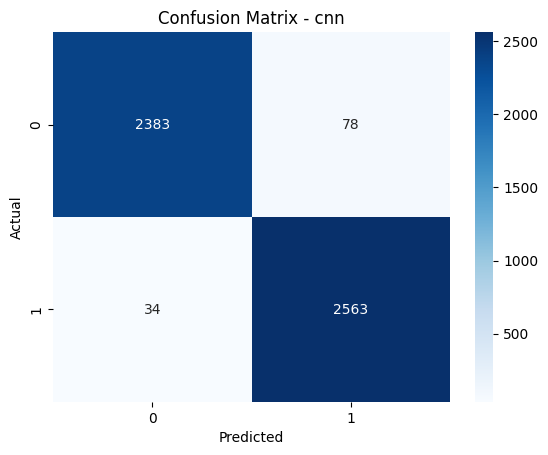

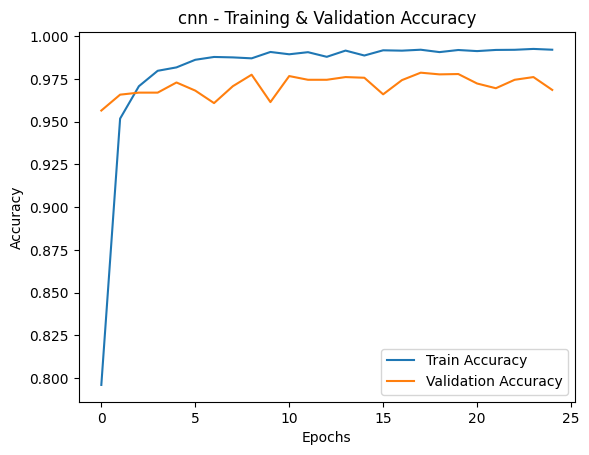

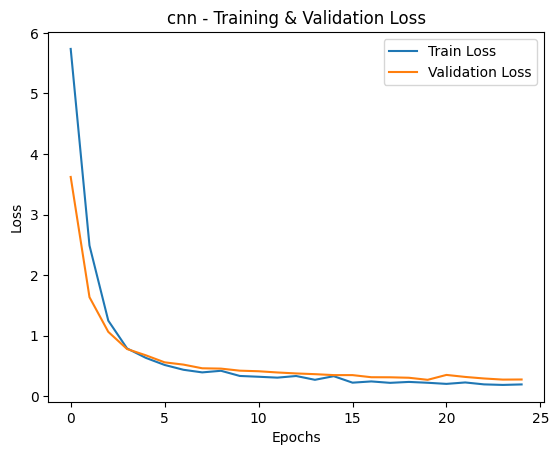

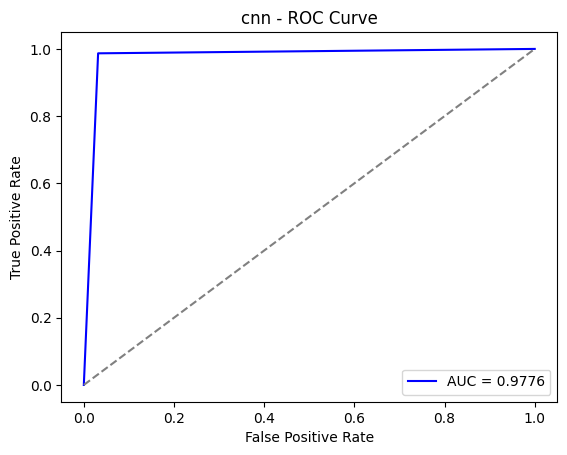

2025/02/24 02:41:45 INFO mlflow.tracking.fluent: Experiment with name 'cnn with LR 0.0001 and Batch 32' does not exist. Creating a new experiment.


Epoch 1/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.9958 - loss: 0.1725 - val_accuracy: 0.9786 - val_loss: 0.2094
Epoch 2/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9978 - loss: 0.1164 - val_accuracy: 0.9781 - val_loss: 0.1858
Epoch 3/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.9958 - loss: 0.1086 - val_accuracy: 0.9751 - val_loss: 0.2407
Epoch 4/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.9931 - loss: 0.1691 - val_accuracy: 0.9751 - val_loss: 0.2294
Epoch 5/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.9966 - loss: 0.1235 - val_accuracy: 0.9775 - val_loss: 0.2040
Epoch 6/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9957 - loss: 0.1185 - val_accuracy: 0.9784 - val_loss: 0.1934
Epoch 7/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9947 - loss: 0.1186 - val_accuracy: 0.9713 - val_loss: 0.2588
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
test_los

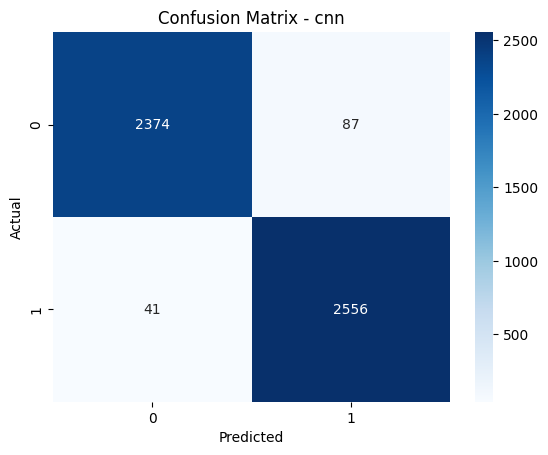

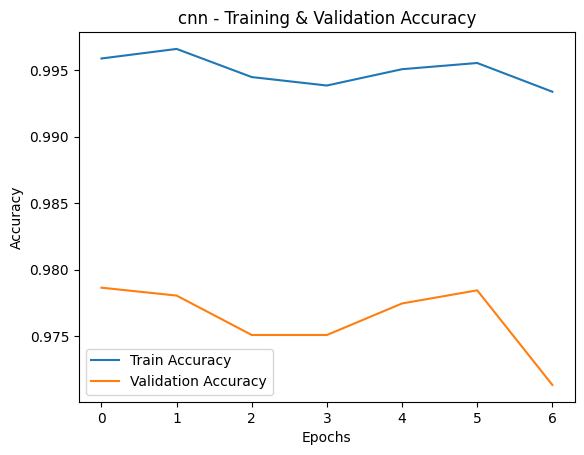

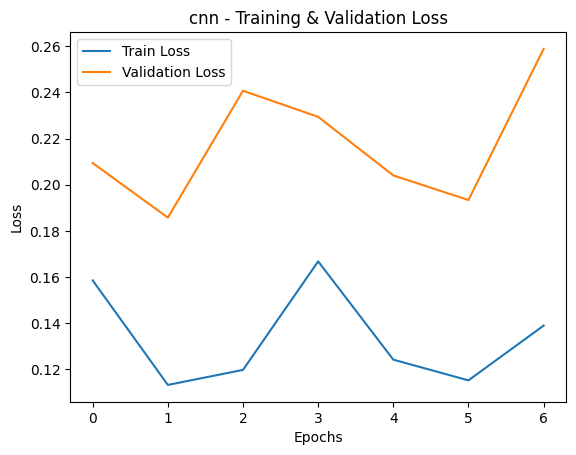

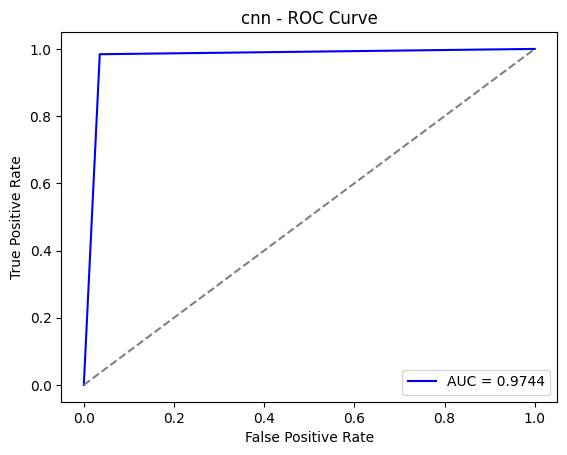

2025/02/24 02:44:00 INFO mlflow.tracking.fluent: Experiment with name 'cnn with LR 0.0001 and Batch 64' does not exist. Creating a new experiment.


Epoch 1/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.9975 - loss: 0.0957 - val_accuracy: 0.9794 - val_loss: 0.1595
Epoch 2/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9983 - loss: 0.0755 - val_accuracy: 0.9777 - val_loss: 0.1600
Epoch 3/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9981 - loss: 0.0679 - val_accuracy: 0.9763 - val_loss: 0.1593
Epoch 4/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9978 - loss: 0.0626 - val_accuracy: 0.9773 - val_loss: 0.1619
Epoch 5/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.9972 - loss: 0.0732 - val_accuracy: 0.9769 - val_loss: 0.1728
Epoch 6/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9949 - loss: 0.1032 - val_accuracy: 0.9782 - val_loss: 0.1928
Epoch 7/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.9964 - loss: 0.1030 - val_accuracy: 0.9781 - val_loss: 0.1783
Epoch 8/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9968 - loss: 0.0866 - 

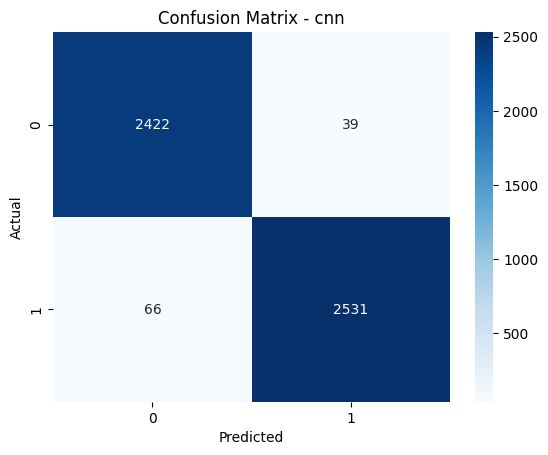

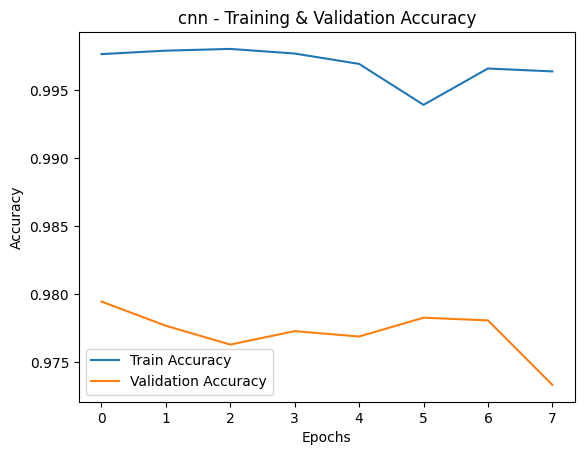

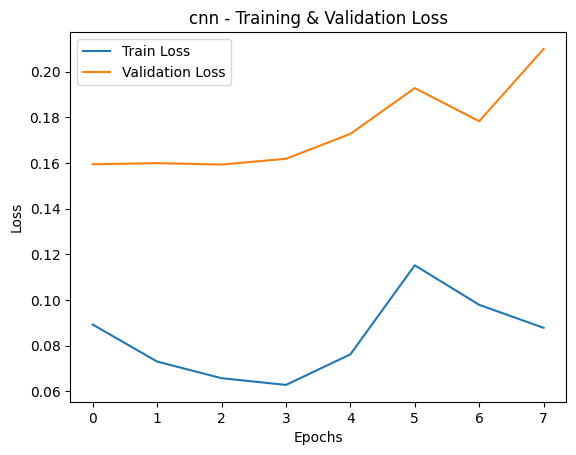

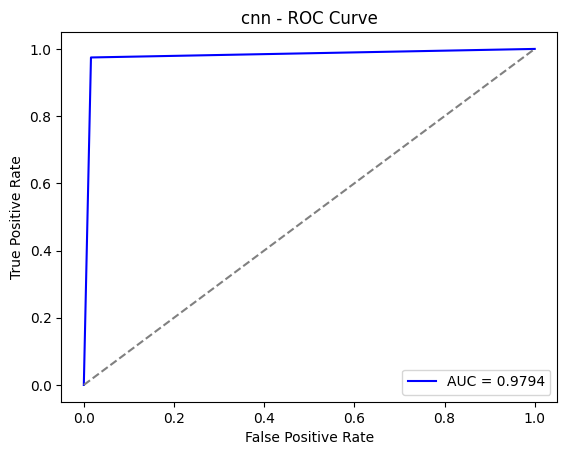

In [ ]:
# CNN Model Training
for lr in LEARNING_RATES:
  cnn_model =  build_cnn(vocab_size=len(word_index) + 1,
                          embedding_matrix=embedding_matrix, learning_rate=lr)
  model_name = "cnn"
  train_and_evaluate(cnn_model, model_name, lr, X_train_padded, y_train,
                      X_val_padded, y_val, X_test_padded, y_test)

### CNN + LTSM

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │       1,709,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,709,400 (6.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,709,400 (6.52 MB)

2025/02/24 02:59:02 INFO mlflow.tracking.fluent: Experiment with name 'cnn_ltsm with LR 0.001 and Batch 16' does not exist. Creating a new experiment.


Epoch 1/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 69s 37ms/step - accuracy: 0.8649 - loss: 0.2979 - val_accuracy: 0.9664 - val_loss: 0.0993
Epoch 2/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 55s 38ms/step - accuracy: 0.9752 - loss: 0.0756 - val_accuracy: 0.9680 - val_loss: 0.0911
Epoch 3/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 81s 37ms/step - accuracy: 0.9810 - loss: 0.0544 - val_accuracy: 0.9747 - val_loss: 0.0727
Epoch 4/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 84s 38ms/step - accuracy: 0.9866 - loss: 0.0409 - val_accuracy: 0.9806 - val_loss: 0.0640
Epoch 5/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - accuracy: 0.9882 - loss: 0.0371 - val_accuracy: 0.9715 - val_loss: 0.0855
Epoch 6/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 81s 37ms/step - accuracy: 0.9905 - loss: 0.0291 - val_accuracy: 0.9664 - val_loss: 0.1043
Epoch 7/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 54s 37ms/step - accuracy: 0.9909 - loss: 0.0255 - val_accuracy: 0.9824 - val_loss: 0.0671
Epoch 8/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 55s 37ms/step - accuracy: 0.9930 -

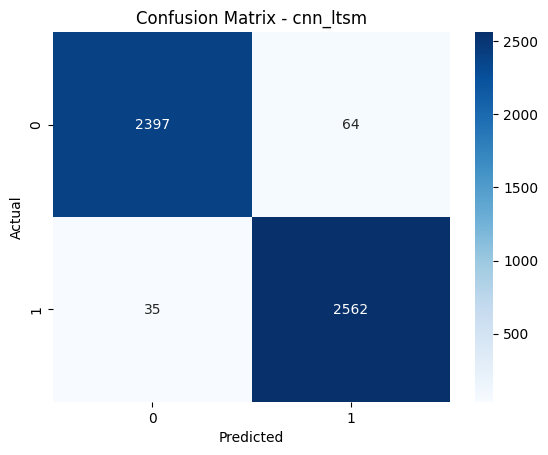

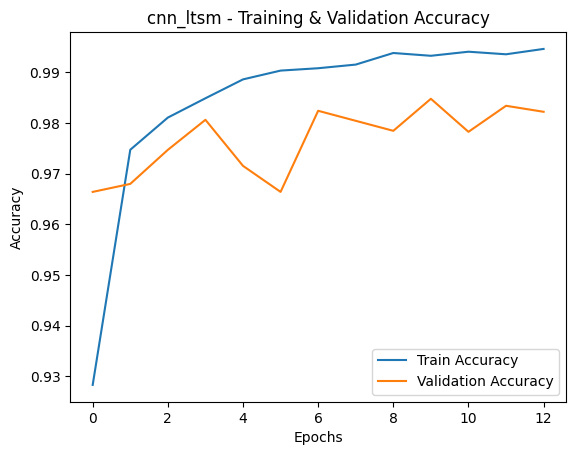

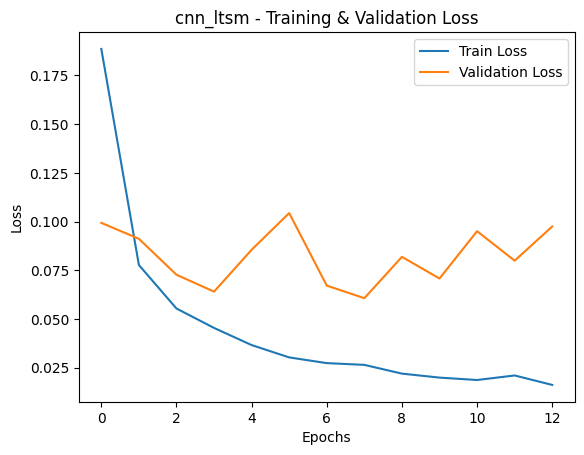

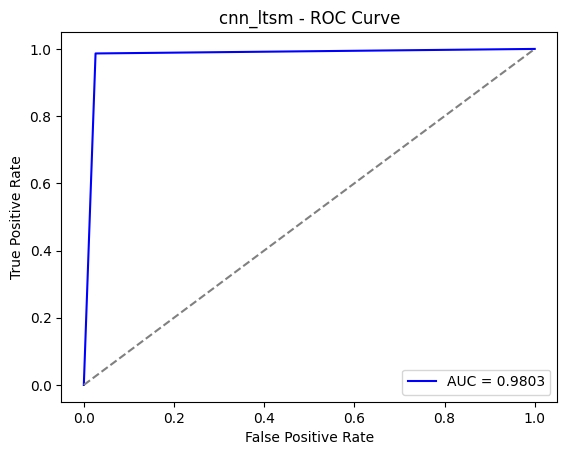

2025/02/24 03:15:22 INFO mlflow.tracking.fluent: Experiment with name 'cnn_ltsm with LR 0.001 and Batch 32' does not exist. Creating a new experiment.


Epoch 1/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - accuracy: 0.9946 - loss: 0.0177 - val_accuracy: 0.9852 - val_loss: 0.0804
Epoch 2/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.9964 - loss: 0.0116 - val_accuracy: 0.9824 - val_loss: 0.0839
Epoch 3/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9958 - loss: 0.0131 - val_accuracy: 0.9852 - val_loss: 0.0782
Epoch 4/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - accuracy: 0.9969 - loss: 0.0098 - val_accuracy: 0.9844 - val_loss: 0.0697
Epoch 5/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.9969 - loss: 0.0096 - val_accuracy: 0.9860 - val_loss: 0.0696
Epoch 6/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9955 - loss: 0.0150 - val_accuracy: 0.9860 - val_loss: 0.0603
Epoch 7/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9973 - loss: 0.0084 - val_accuracy: 0.9846 - val_loss: 0.0691
Epoch 8/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.9979 - loss: 0.0078 - 

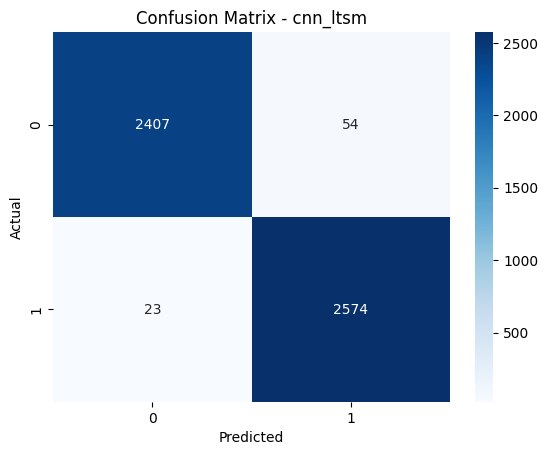

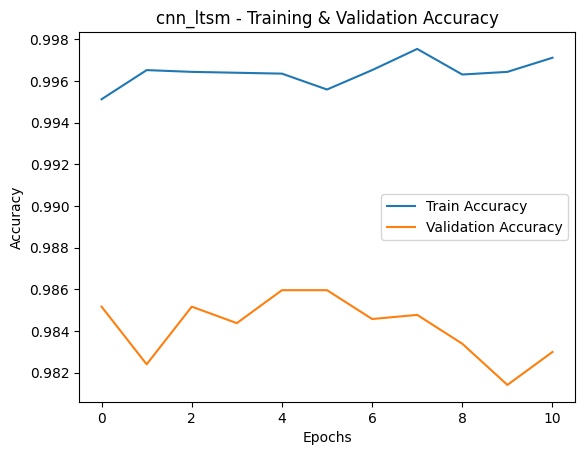

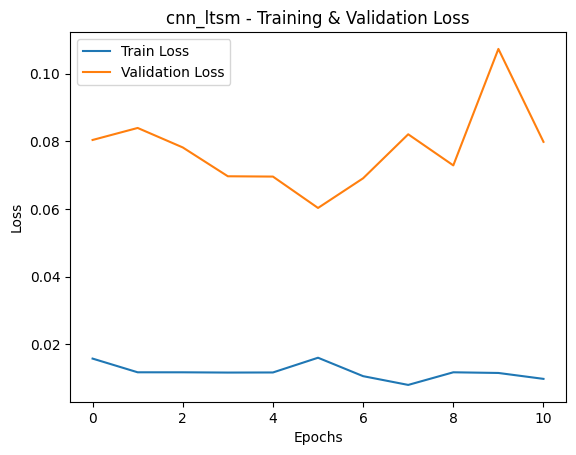

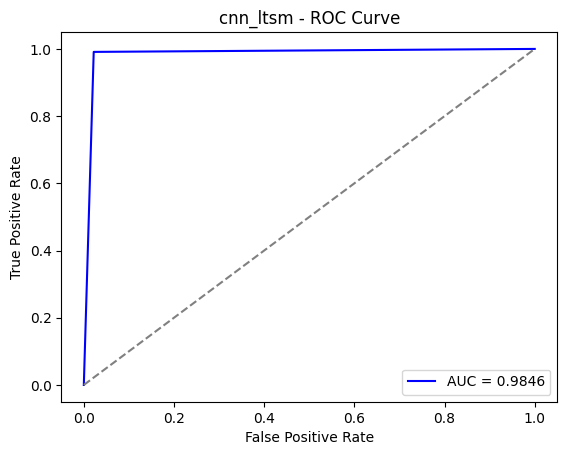

2025/02/24 03:22:37 INFO mlflow.tracking.fluent: Experiment with name 'cnn_ltsm with LR 0.001 and Batch 64' does not exist. Creating a new experiment.


Epoch 1/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.9983 - loss: 0.0058 - val_accuracy: 0.9850 - val_loss: 0.0833
Epoch 2/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.9975 - loss: 0.0077 - val_accuracy: 0.9840 - val_loss: 0.0899
Epoch 3/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.9978 - loss: 0.0063 - val_accuracy: 0.9864 - val_loss: 0.0770
Epoch 4/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.9987 - loss: 0.0047 - val_accuracy: 0.9846 - val_loss: 0.0769
Epoch 5/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.9983 - loss: 0.0067 - val_accuracy: 0.9868 - val_loss: 0.0840
Epoch 6/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.9979 - loss: 0.0074 - val_accuracy: 0.9846 - val_loss: 0.0700
Epoch 7/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.9971 - loss: 0.0090 - val_accuracy: 0.9838 - val_loss: 0.0843
Epoch 8/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.9976 - loss: 0.0074 - 

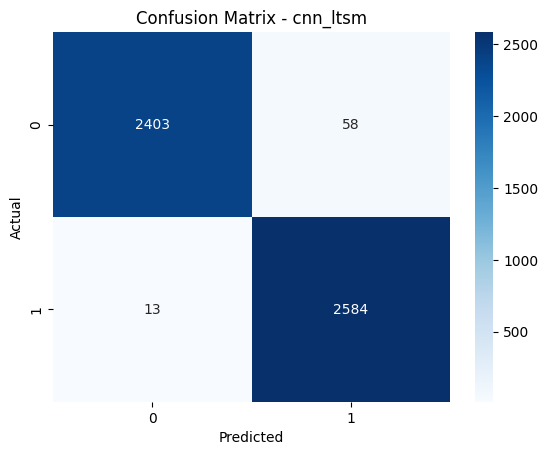

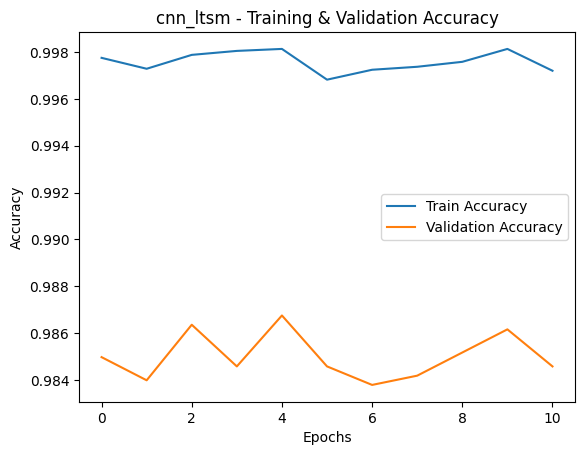

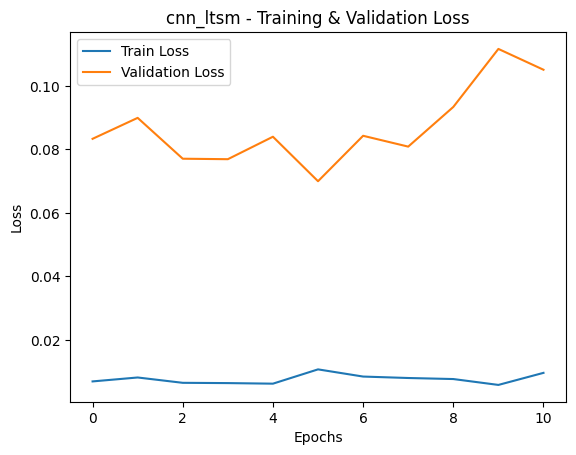

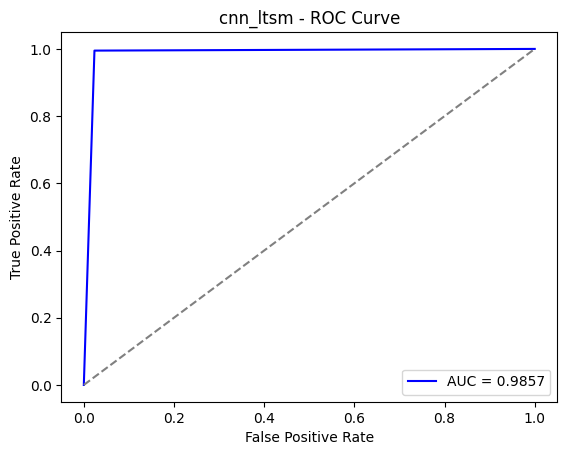

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │       1,709,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,709,400 (6.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,709,400 (6.52 MB)

2025/02/24 03:26:26 INFO mlflow.tracking.fluent: Experiment with name 'cnn_ltsm with LR 0.0005 and Batch 16' does not exist. Creating a new experiment.


Epoch 1/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 62s 39ms/step - accuracy: 0.8496 - loss: 0.3161 - val_accuracy: 0.9731 - val_loss: 0.0779
Epoch 2/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 82s 39ms/step - accuracy: 0.9752 - loss: 0.0728 - val_accuracy: 0.9788 - val_loss: 0.0583
Epoch 3/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 56s 38ms/step - accuracy: 0.9831 - loss: 0.0505 - val_accuracy: 0.9741 - val_loss: 0.0794
Epoch 4/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step - accuracy: 0.9885 - loss: 0.0337 - val_accuracy: 0.9792 - val_loss: 0.0611
Epoch 5/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 80s 38ms/step - accuracy: 0.9933 - loss: 0.0229 - val_accuracy: 0.9784 - val_loss: 0.0734
Epoch 6/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 56s 38ms/step - accuracy: 0.9826 - loss: 0.0548 - val_accuracy: 0.9808 - val_loss: 0.0762
Epoch 7/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 84s 39ms/step - accuracy: 0.9942 - loss: 0.0197 - val_accuracy: 0.9850 - val_loss: 0.0549
Epoch 8/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 81s 39ms/step - accuracy: 0.9954 -

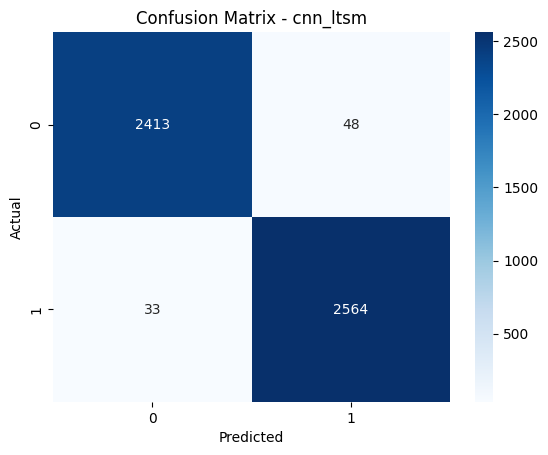

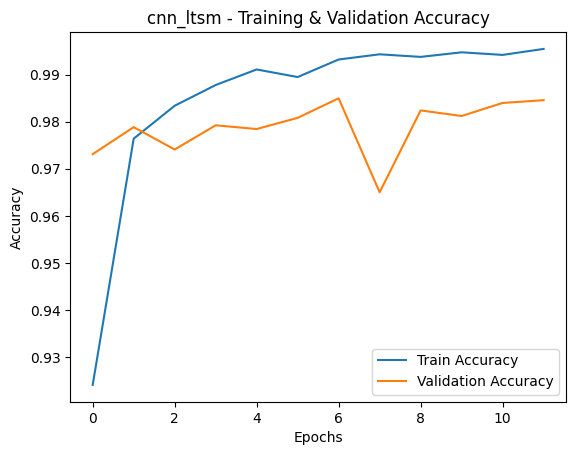

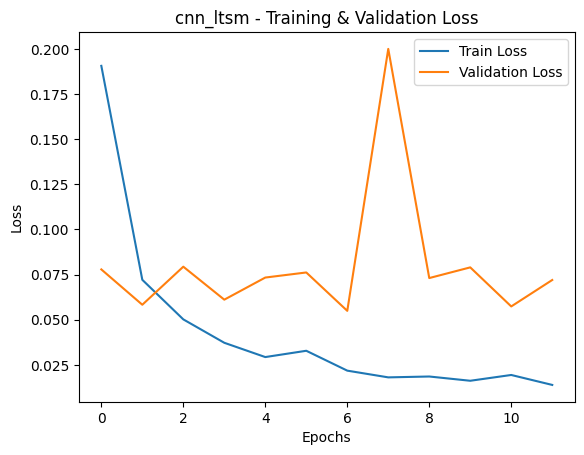

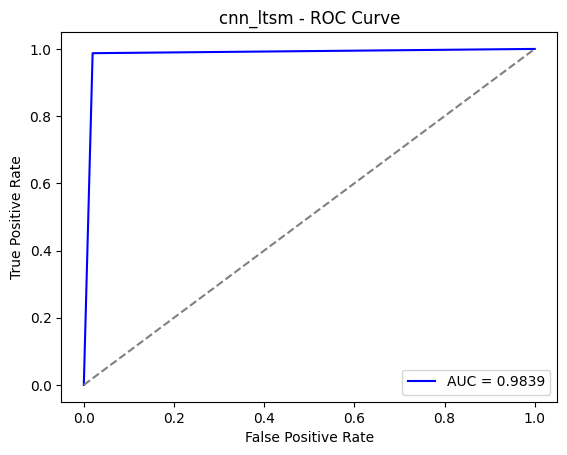

2025/02/24 03:40:32 INFO mlflow.tracking.fluent: Experiment with name 'cnn_ltsm with LR 0.0005 and Batch 32' does not exist. Creating a new experiment.


Epoch 1/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.9966 - loss: 0.0126 - val_accuracy: 0.9737 - val_loss: 0.1433
Epoch 2/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - accuracy: 0.9962 - loss: 0.0115 - val_accuracy: 0.9846 - val_loss: 0.0736
Epoch 3/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.9974 - loss: 0.0092 - val_accuracy: 0.9848 - val_loss: 0.0701
Epoch 4/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.9966 - loss: 0.0092 - val_accuracy: 0.9838 - val_loss: 0.0789
Epoch 5/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - accuracy: 0.9969 - loss: 0.0098 - val_accuracy: 0.9832 - val_loss: 0.0784
Epoch 6/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.9966 - loss: 0.0092 - val_accuracy: 0.9836 - val_loss: 0.0828
Epoch 7/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 28s 38ms/step - accuracy: 0.9966 - loss: 0.0109 - val_accuracy: 0.9836 - val_loss: 0.0886
Epoch 8/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.9972 - loss: 0.0100 - 

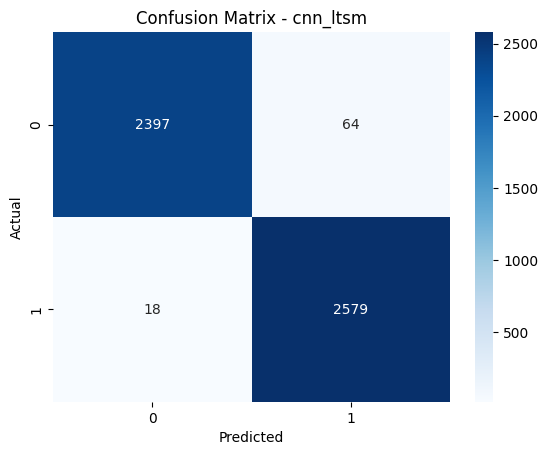

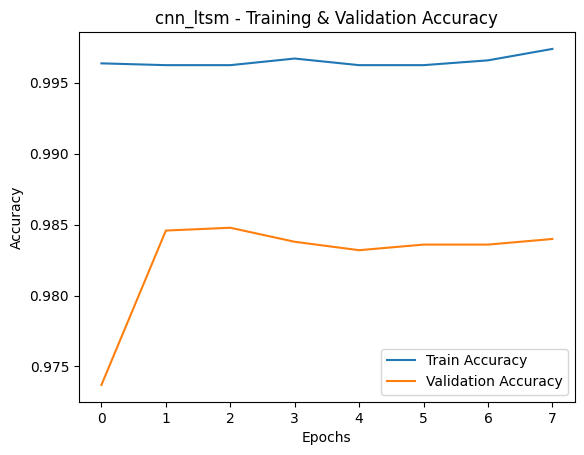

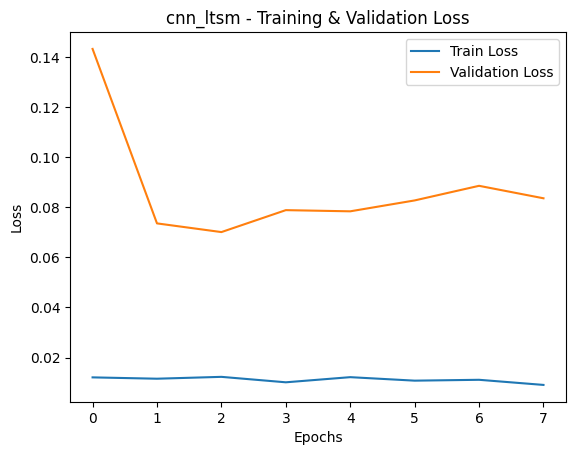

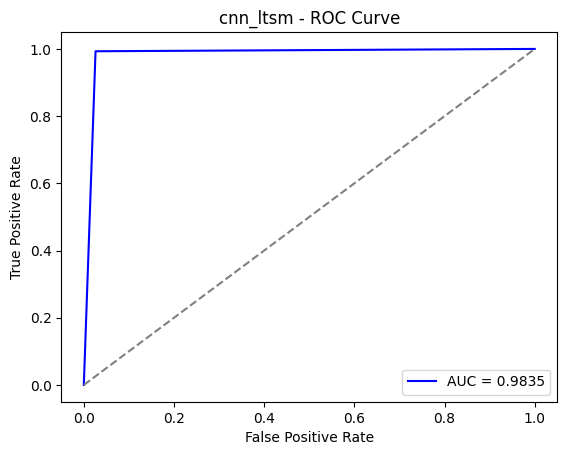

2025/02/24 03:45:19 INFO mlflow.tracking.fluent: Experiment with name 'cnn_ltsm with LR 0.0005 and Batch 64' does not exist. Creating a new experiment.


Epoch 1/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9980 - loss: 0.0070 - val_accuracy: 0.9804 - val_loss: 0.1139
Epoch 2/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.9981 - loss: 0.0061 - val_accuracy: 0.9854 - val_loss: 0.0939
Epoch 3/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.9980 - loss: 0.0074 - val_accuracy: 0.9856 - val_loss: 0.0899
Epoch 4/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.9985 - loss: 0.0052 - val_accuracy: 0.9822 - val_loss: 0.1258
Epoch 5/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - accuracy: 0.9977 - loss: 0.0071 - val_accuracy: 0.9812 - val_loss: 0.1159
Epoch 6/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9967 - loss: 0.0089 - val_accuracy: 0.9442 - val_loss: 0.3175
Epoch 7/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.9963 - loss: 0.0094 - val_accuracy: 0.9842 - val_loss: 0.0870
Epoch 8/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.9980 - loss: 0.0064 - 

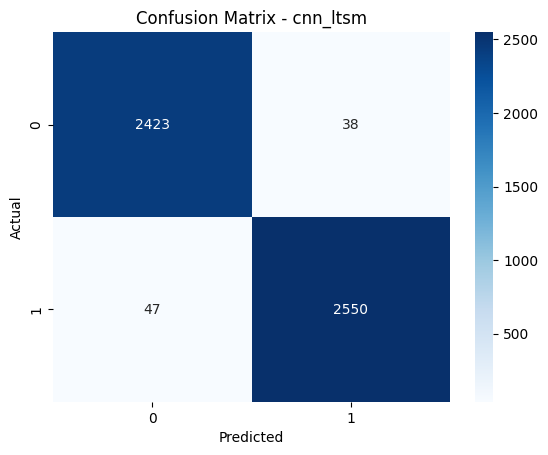

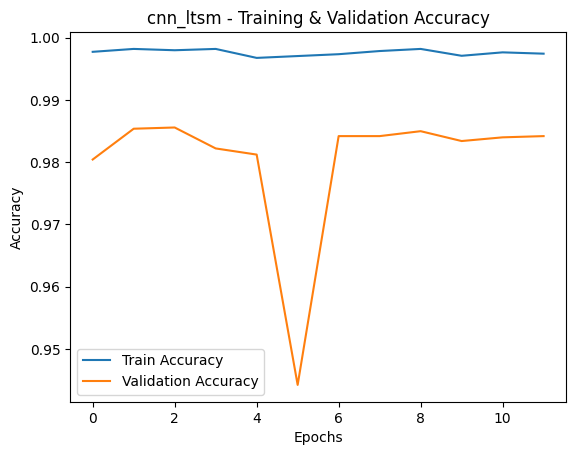

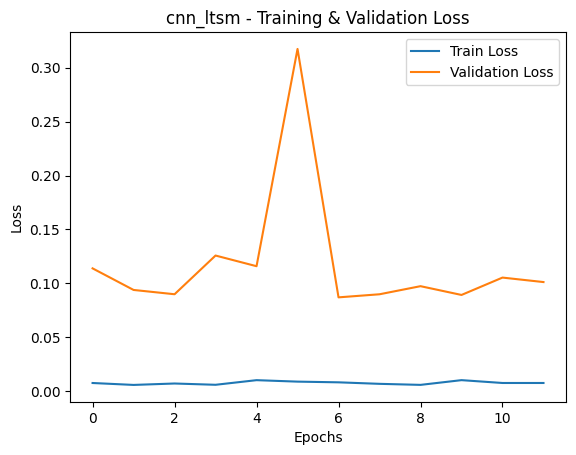

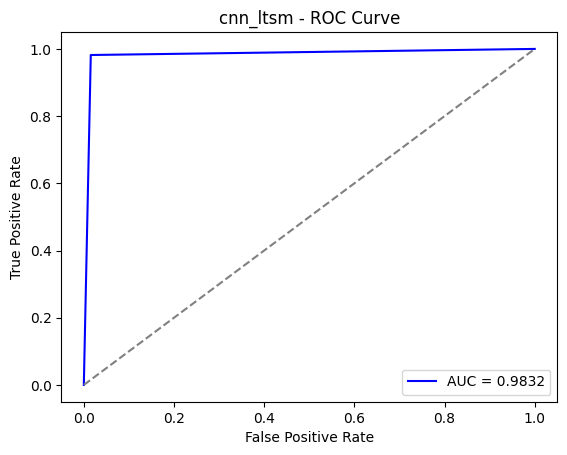

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │       1,709,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,709,400 (6.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,709,400 (6.52 MB)

2025/02/24 03:49:31 INFO mlflow.tracking.fluent: Experiment with name 'cnn_ltsm with LR 0.0001 and Batch 16' does not exist. Creating a new experiment.


Epoch 1/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 63s 40ms/step - accuracy: 0.7584 - loss: 0.4560 - val_accuracy: 0.9181 - val_loss: 0.1956
Epoch 2/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 59s 40ms/step - accuracy: 0.9584 - loss: 0.1326 - val_accuracy: 0.9377 - val_loss: 0.1816
Epoch 3/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 81s 39ms/step - accuracy: 0.9759 - loss: 0.0813 - val_accuracy: 0.9670 - val_loss: 0.0972
Epoch 4/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 81s 39ms/step - accuracy: 0.9845 - loss: 0.0487 - val_accuracy: 0.9739 - val_loss: 0.0827
Epoch 5/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 83s 39ms/step - accuracy: 0.9875 - loss: 0.0377 - val_accuracy: 0.9796 - val_loss: 0.0650
Epoch 6/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step - accuracy: 0.9928 - loss: 0.0247 - val_accuracy: 0.9757 - val_loss: 0.0936
Epoch 7/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 81s 38ms/step - accuracy: 0.9956 - loss: 0.0157 - val_accuracy: 0.9792 - val_loss: 0.0846
Epoch 8/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - accuracy: 0.9964 -

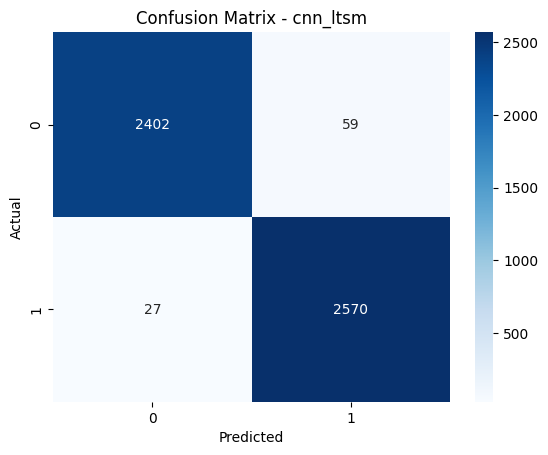

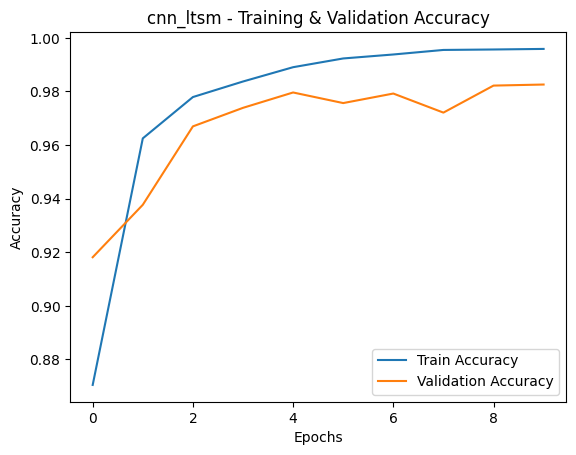

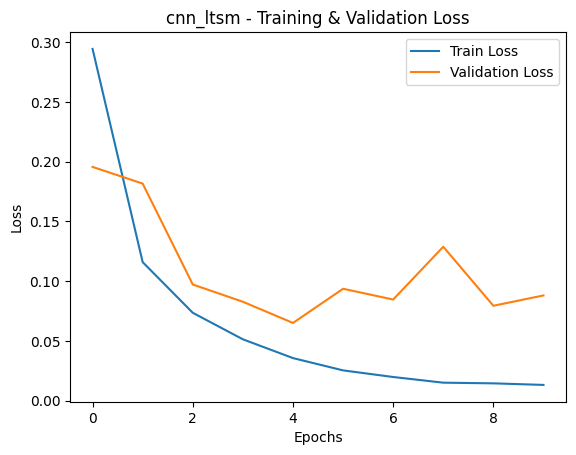

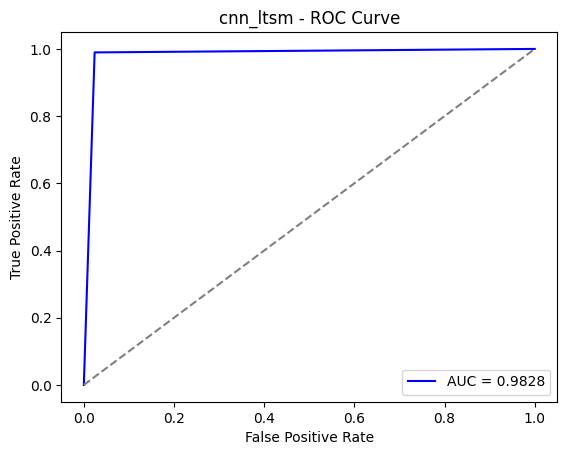

2025/02/24 04:01:54 INFO mlflow.tracking.fluent: Experiment with name 'cnn_ltsm with LR 0.0001 and Batch 32' does not exist. Creating a new experiment.


Epoch 1/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 29s 40ms/step - accuracy: 0.9953 - loss: 0.0171 - val_accuracy: 0.9782 - val_loss: 0.0841
Epoch 2/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.9956 - loss: 0.0148 - val_accuracy: 0.9828 - val_loss: 0.0801
Epoch 3/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.9956 - loss: 0.0141 - val_accuracy: 0.9820 - val_loss: 0.0843
Epoch 4/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.9977 - loss: 0.0075 - val_accuracy: 0.9830 - val_loss: 0.0935
Epoch 5/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 0.9984 - loss: 0.0060 - val_accuracy: 0.9826 - val_loss: 0.0876
Epoch 6/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.9969 - loss: 0.0103 - val_accuracy: 0.9826 - val_loss: 0.0921
Epoch 7/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.9965 - loss: 0.0118 - val_accuracy: 0.9826 - val_loss: 0.0950
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
test_l

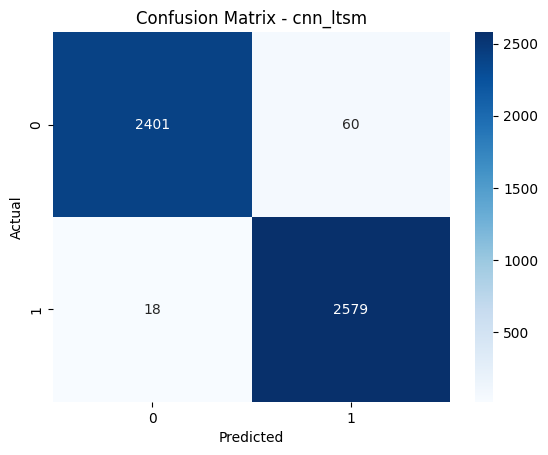

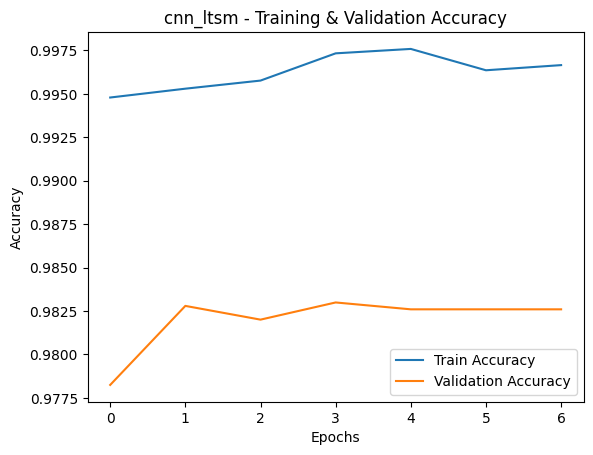

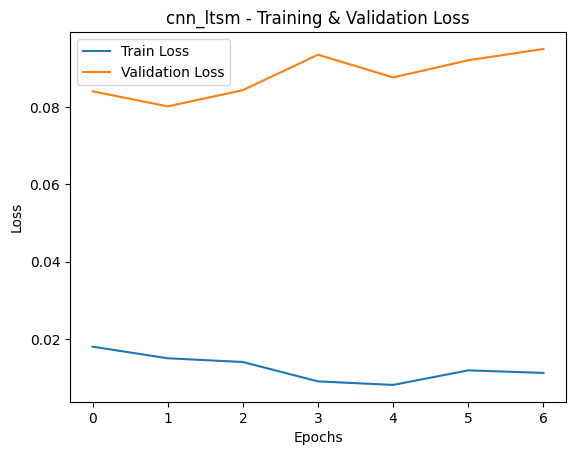

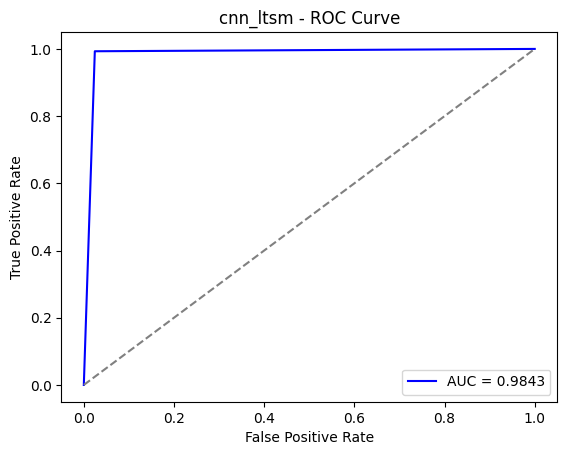

2025/02/24 04:06:39 INFO mlflow.tracking.fluent: Experiment with name 'cnn_ltsm with LR 0.0001 and Batch 64' does not exist. Creating a new experiment.


Epoch 1/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9975 - loss: 0.0093 - val_accuracy: 0.9727 - val_loss: 0.1400
Epoch 2/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - accuracy: 0.9975 - loss: 0.0091 - val_accuracy: 0.9808 - val_loss: 0.0931
Epoch 3/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.9978 - loss: 0.0077 - val_accuracy: 0.9822 - val_loss: 0.0946
Epoch 4/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.9982 - loss: 0.0069 - val_accuracy: 0.9816 - val_loss: 0.1029
Epoch 5/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.9983 - loss: 0.0054 - val_accuracy: 0.9816 - val_loss: 0.1087
Epoch 6/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.9977 - loss: 0.0088 - val_accuracy: 0.9747 - val_loss: 0.1403
Epoch 7/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.9979 - loss: 0.0071 - val_accuracy: 0.9822 - val_loss: 0.1027
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
test_l

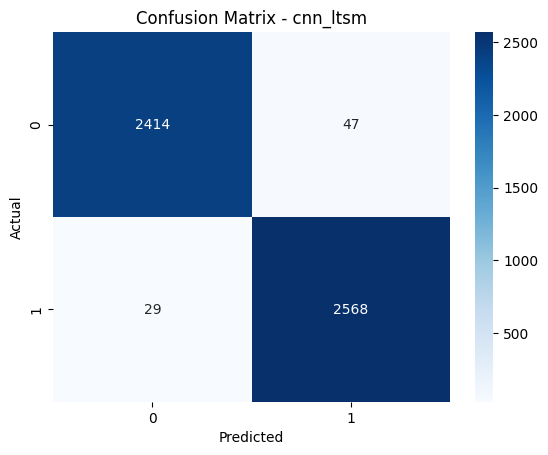

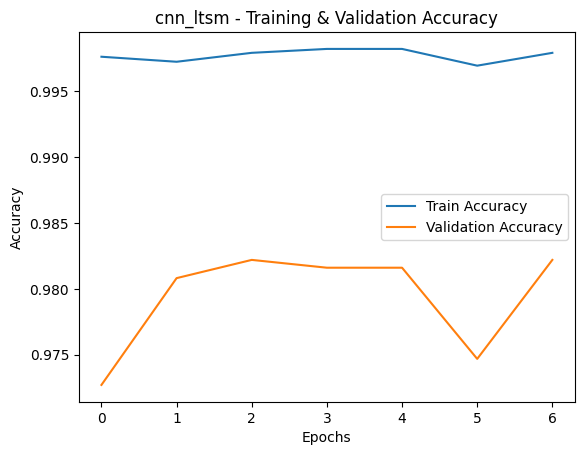

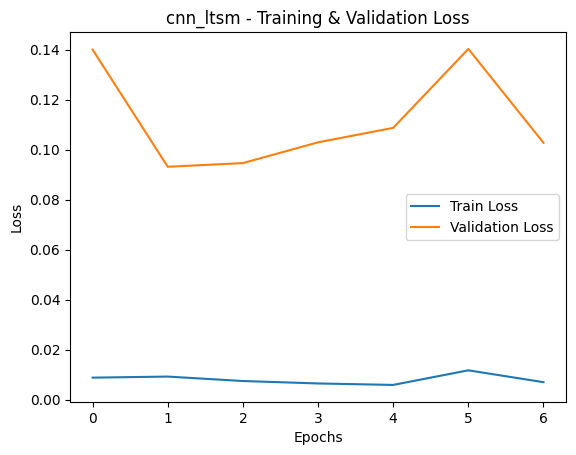

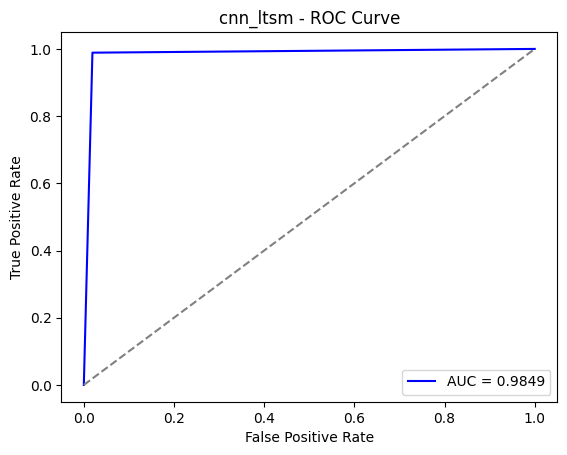

In [ ]:
# CNN + LTSM Model Training
for lr in LEARNING_RATES:
  cnn_ltsm_model =  build_cnn_ltsm(vocab_size=len(word_index) + 1,
                          embedding_matrix=embedding_matrix, learning_rate=lr)
  model_name = "cnn_ltsm"
  train_and_evaluate(cnn_ltsm_model, model_name, lr,
                      X_train_padded, y_train, X_val_padded, y_val,
                      X_test_padded, y_test)

### RNN + LTSM

2025/02/24 07:04:32 WARNING mlflow.tracing.processor.mlflow: Creating a trace within the default experiment with id '0'. It is strongly recommended to not use the default experiment to log traces due to ambiguous search results and probable performance issues over time due to directory table listing performance degradation with high volumes of directories within a specific path. To avoid performance and disambiguation issues, set the experiment for your environment using `mlflow.set_experiment()` API.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       1,709,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,709,400 (6.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,709,400 (6.52 MB)

Epoch 1/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 133s 86ms/step - accuracy: 0.8630 - loss: 0.3227 - val_accuracy: 0.9177 - val_loss: 0.2326
Epoch 2/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 141s 87ms/step - accuracy: 0.9528 - loss: 0.1594 - val_accuracy: 0.9757 - val_loss: 0.0731
Epoch 3/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 140s 86ms/step - accuracy: 0.9753 - loss: 0.0793 - val_accuracy: 0.9765 - val_loss: 0.0685
Epoch 4/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 130s 88ms/step - accuracy: 0.9767 - loss: 0.0777 - val_accuracy: 0.9790 - val_loss: 0.0574
Epoch 5/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 142s 88ms/step - accuracy: 0.9860 - loss: 0.0500 - val_accuracy: 0.9707 - val_loss: 0.0813
Epoch 6/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 140s 86ms/step - accuracy: 0.9851 - loss: 0.0503 - val_accuracy: 0.9838 - val_loss: 0.0558
Epoch 7/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 143s 87ms/step - accuracy: 0.9875 - loss: 0.0411 - val_accuracy: 0.9822 - val_loss: 0.0680
Epoch 8/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 128s 87ms/step - accuracy: 

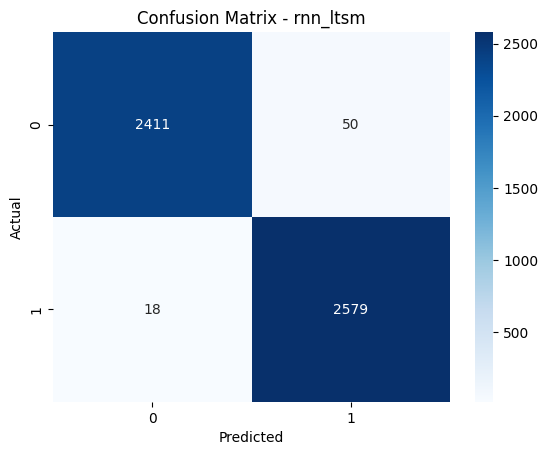

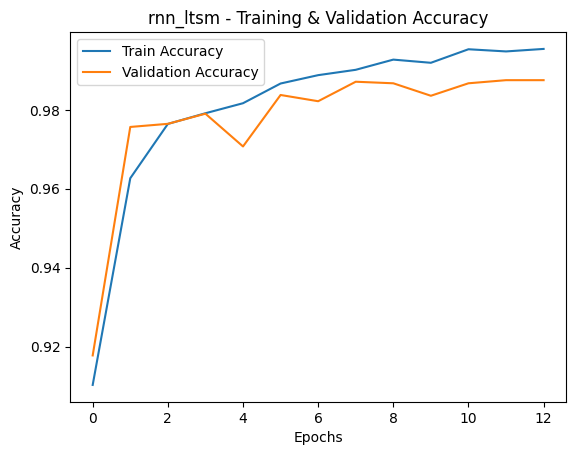

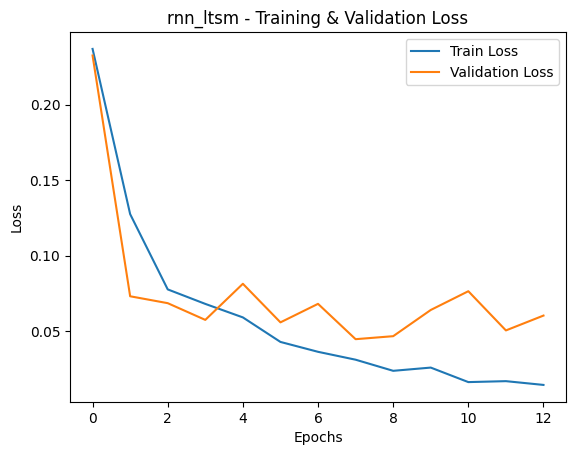

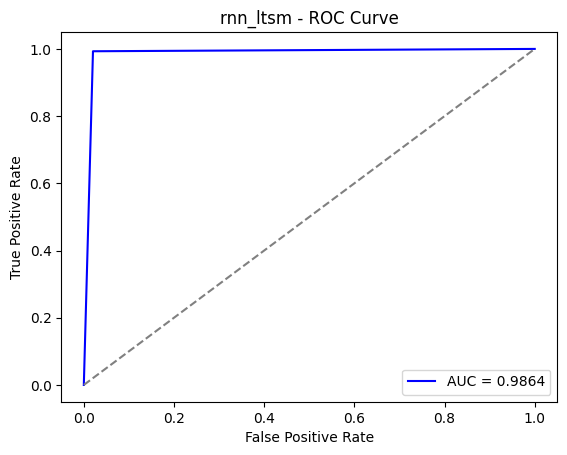

Epoch 1/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 59s 80ms/step - accuracy: 0.9946 - loss: 0.0201 - val_accuracy: 0.9775 - val_loss: 0.0820
Epoch 2/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 59s 80ms/step - accuracy: 0.9948 - loss: 0.0182 - val_accuracy: 0.9881 - val_loss: 0.0529
Epoch 3/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 82s 80ms/step - accuracy: 0.9955 - loss: 0.0129 - val_accuracy: 0.9885 - val_loss: 0.0477
Epoch 4/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 59s 79ms/step - accuracy: 0.9970 - loss: 0.0104 - val_accuracy: 0.9856 - val_loss: 0.0594
Epoch 5/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 82s 79ms/step - accuracy: 0.9973 - loss: 0.0095 - val_accuracy: 0.9885 - val_loss: 0.0678
Epoch 6/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 83s 81ms/step - accuracy: 0.9957 - loss: 0.0120 - val_accuracy: 0.9826 - val_loss: 0.0956
Epoch 7/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 82s 82ms/step - accuracy: 0.9944 - loss: 0.0150 - val_accuracy: 0.9891 - val_loss: 0.0460
Epoch 8/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 82s 82ms/step - accuracy: 0.9979 - loss: 0.0078 - 

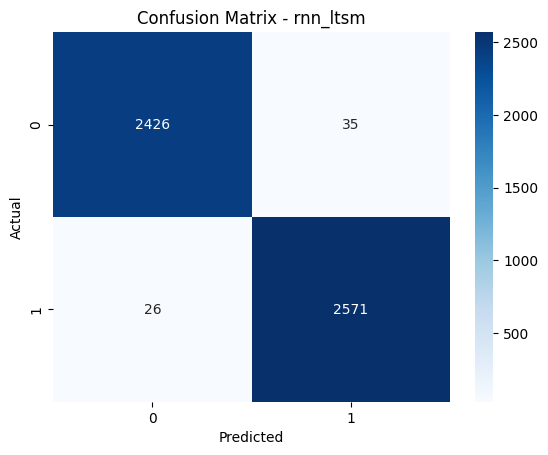

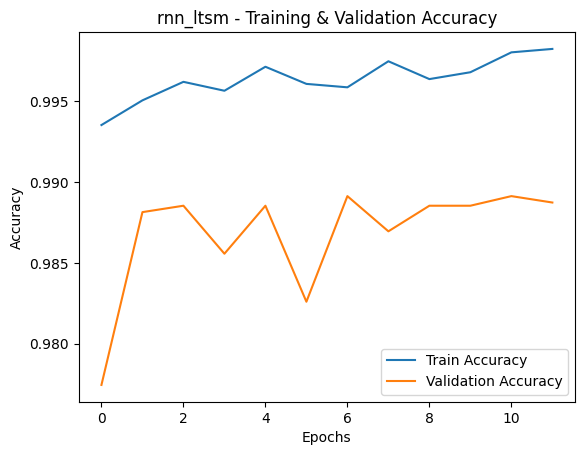

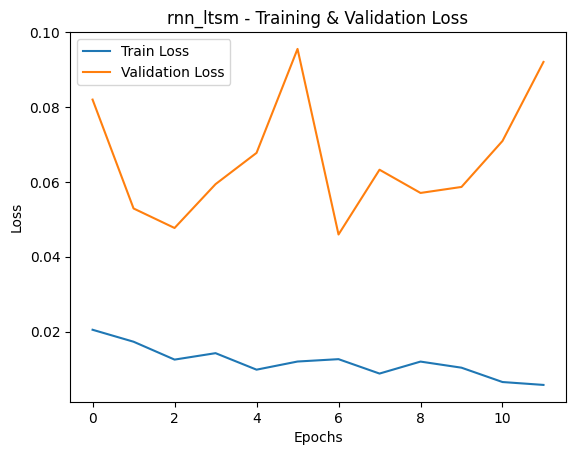

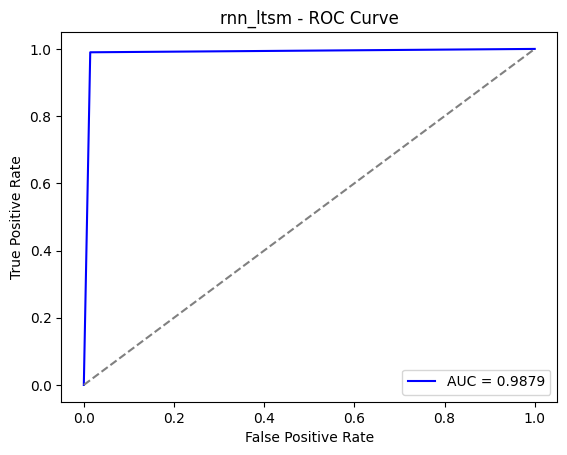

Epoch 1/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 39s 107ms/step - accuracy: 0.9982 - loss: 0.0076 - val_accuracy: 0.9864 - val_loss: 0.0740
Epoch 2/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 37s 101ms/step - accuracy: 0.9975 - loss: 0.0074 - val_accuracy: 0.9879 - val_loss: 0.0586
Epoch 3/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 41s 101ms/step - accuracy: 0.9974 - loss: 0.0087 - val_accuracy: 0.9869 - val_loss: 0.0657
Epoch 4/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - accuracy: 0.9982 - loss: 0.0060 - val_accuracy: 0.9893 - val_loss: 0.0744
Epoch 5/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 39s 106ms/step - accuracy: 0.9982 - loss: 0.0062 - val_accuracy: 0.9889 - val_loss: 0.0509
Epoch 6/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 38s 102ms/step - accuracy: 0.9979 - loss: 0.0071 - val_accuracy: 0.9899 - val_loss: 0.0700
Epoch 7/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 43s 107ms/step - accuracy: 0.9984 - loss: 0.0052 - val_accuracy: 0.9885 - val_loss: 0.0757
Epoch 8/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 38s 100ms/step - accuracy: 0.9983 - loss: 0

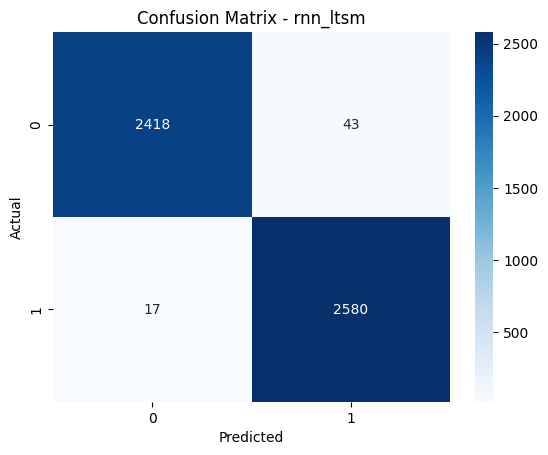

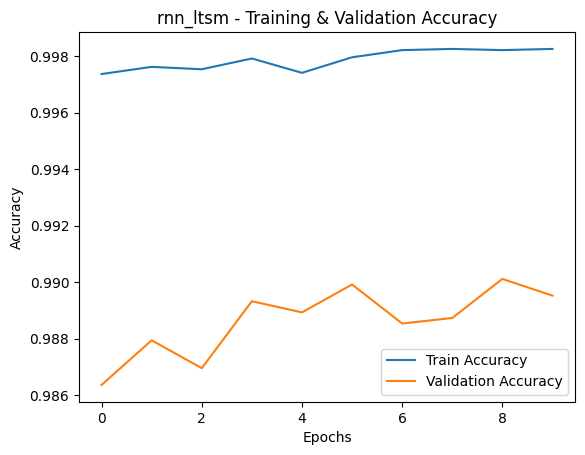

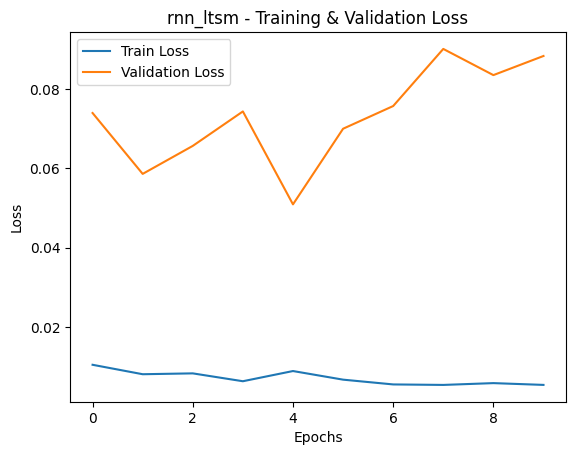

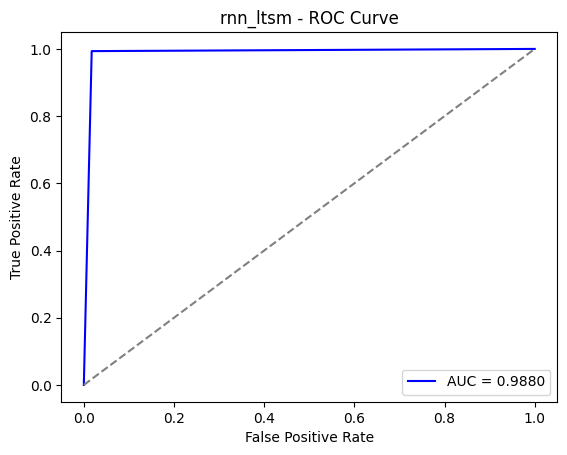

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       1,709,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,709,400 (6.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,709,400 (6.52 MB)

Epoch 1/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 137s 89ms/step - accuracy: 0.8402 - loss: 0.3678 - val_accuracy: 0.9466 - val_loss: 0.1848
Epoch 2/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 131s 89ms/step - accuracy: 0.9547 - loss: 0.1410 - val_accuracy: 0.9593 - val_loss: 0.1119
Epoch 3/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 129s 87ms/step - accuracy: 0.9630 - loss: 0.1153 - val_accuracy: 0.9749 - val_loss: 0.0726
Epoch 4/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 144s 89ms/step - accuracy: 0.9750 - loss: 0.0761 - val_accuracy: 0.9680 - val_loss: 0.1068
Epoch 5/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 129s 87ms/step - accuracy: 0.9808 - loss: 0.0581 - val_accuracy: 0.9777 - val_loss: 0.0670
Epoch 6/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 132s 89ms/step - accuracy: 0.9840 - loss: 0.0496 - val_accuracy: 0.9810 - val_loss: 0.0624
Epoch 7/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 142s 89ms/step - accuracy: 0.9880 - loss: 0.0408 - val_accuracy: 0.9820 - val_loss: 0.0616
Epoch 8/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 140s 88ms/step - accuracy: 

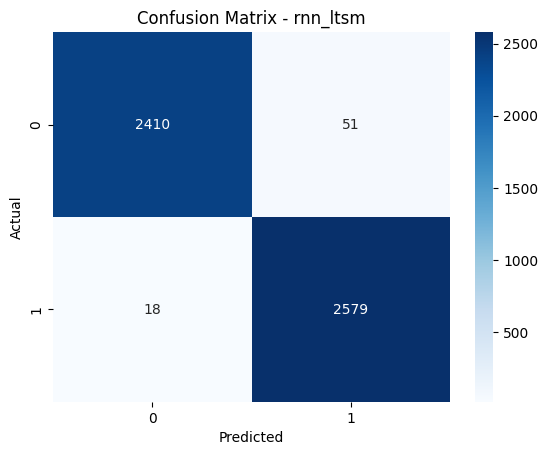

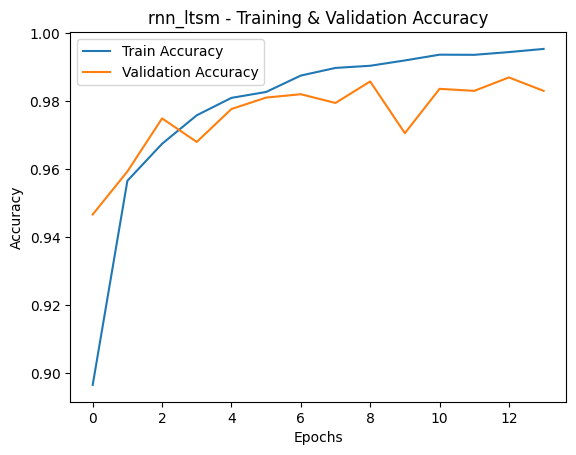

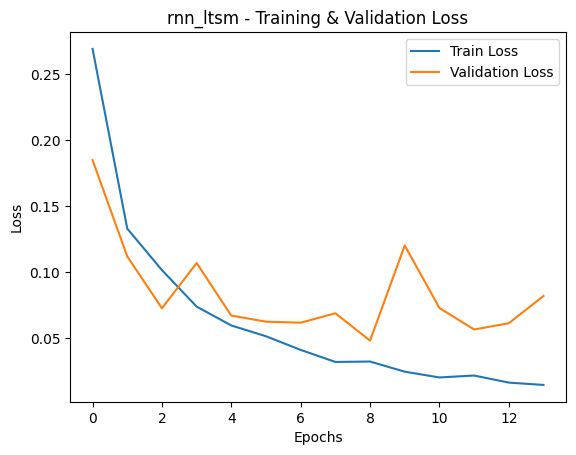

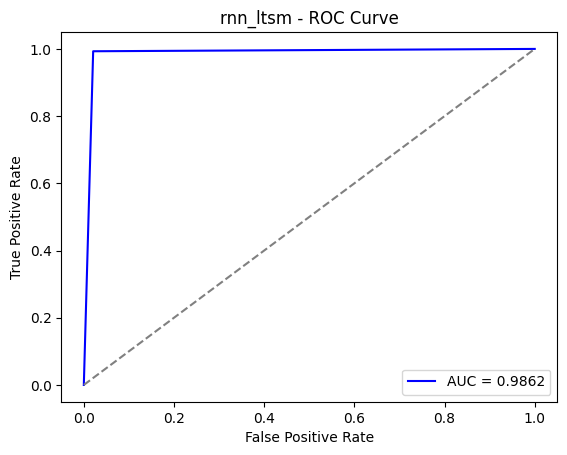

Epoch 1/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 62s 84ms/step - accuracy: 0.9943 - loss: 0.0189 - val_accuracy: 0.9850 - val_loss: 0.0570
Epoch 2/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 61s 83ms/step - accuracy: 0.9962 - loss: 0.0130 - val_accuracy: 0.9850 - val_loss: 0.0596
Epoch 3/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 61s 83ms/step - accuracy: 0.9965 - loss: 0.0124 - val_accuracy: 0.9820 - val_loss: 0.0622
Epoch 4/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 82s 83ms/step - accuracy: 0.9950 - loss: 0.0173 - val_accuracy: 0.9852 - val_loss: 0.0565
Epoch 5/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 61s 82ms/step - accuracy: 0.9969 - loss: 0.0100 - val_accuracy: 0.9869 - val_loss: 0.0748
Epoch 6/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 60s 82ms/step - accuracy: 0.9963 - loss: 0.0132 - val_accuracy: 0.9842 - val_loss: 0.0657
Epoch 7/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 84s 84ms/step - accuracy: 0.9954 - loss: 0.0165 - val_accuracy: 0.9830 - val_loss: 0.0638
Epoch 8/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 82s 85ms/step - accuracy: 0.9976 - loss: 0.0088 - 

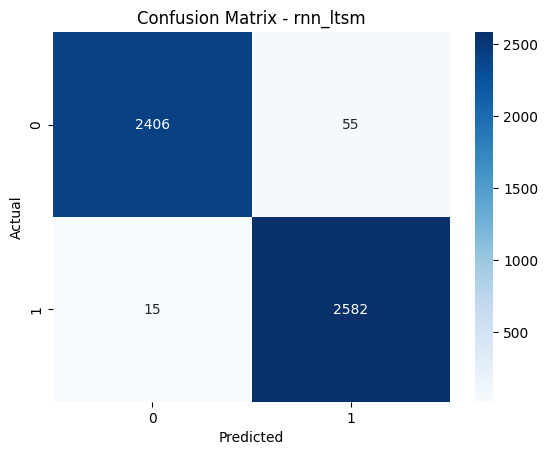

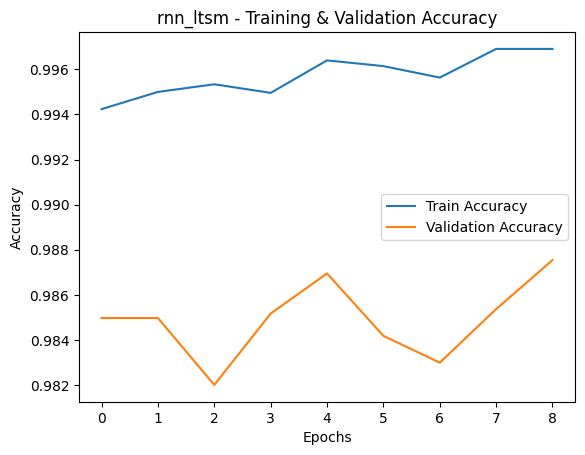

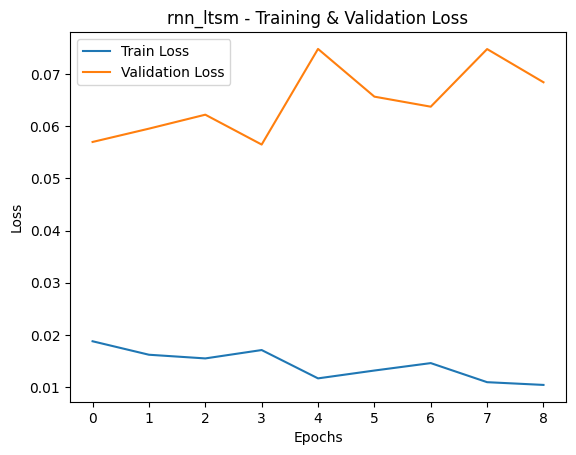

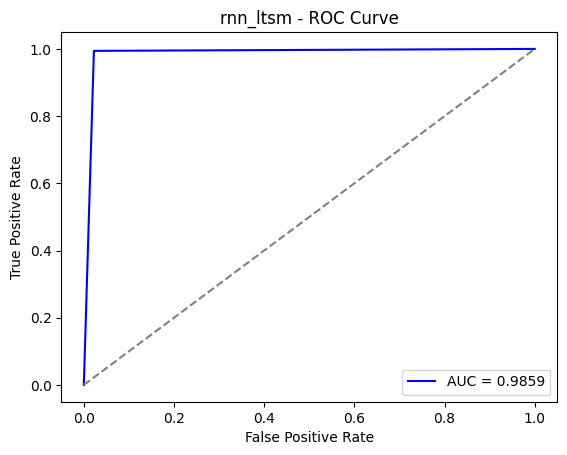

Epoch 1/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 40s 109ms/step - accuracy: 0.9973 - loss: 0.0087 - val_accuracy: 0.9862 - val_loss: 0.0662
Epoch 2/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 38s 102ms/step - accuracy: 0.9982 - loss: 0.0065 - val_accuracy: 0.9854 - val_loss: 0.0931
Epoch 3/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 41s 102ms/step - accuracy: 0.9968 - loss: 0.0112 - val_accuracy: 0.9852 - val_loss: 0.0757
Epoch 4/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 40s 108ms/step - accuracy: 0.9967 - loss: 0.0101 - val_accuracy: 0.9854 - val_loss: 0.0727
Epoch 5/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 40s 108ms/step - accuracy: 0.9977 - loss: 0.0079 - val_accuracy: 0.9860 - val_loss: 0.0812
Epoch 6/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 40s 108ms/step - accuracy: 0.9982 - loss: 0.0062 - val_accuracy: 0.9862 - val_loss: 0.0759
159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step
test_loss: 0.06979625672101974
test_accuracy: 0.9871490597724915
precision: 0.983206106870229
recall: 0.9919137466307277
f1_score:

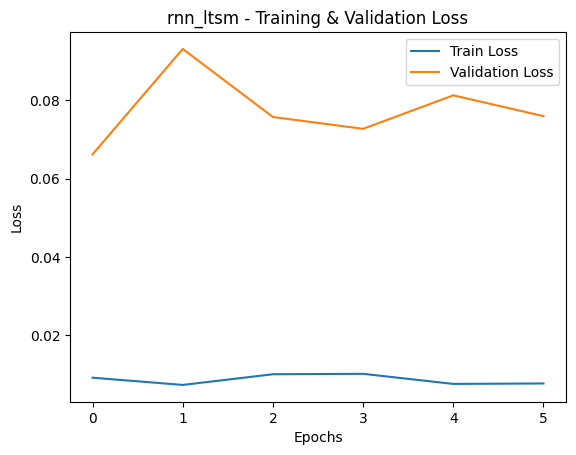

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │       1,709,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,709,400 (6.52 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,709,400 (6.52 MB)

Epoch 1/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 137s 90ms/step - accuracy: 0.7672 - loss: 0.4609 - val_accuracy: 0.8948 - val_loss: 0.2786
Epoch 2/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 142s 90ms/step - accuracy: 0.9289 - loss: 0.2137 - val_accuracy: 0.9525 - val_loss: 0.1299
Epoch 3/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 143s 90ms/step - accuracy: 0.9487 - loss: 0.1488 - val_accuracy: 0.9644 - val_loss: 0.1073
Epoch 4/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 142s 90ms/step - accuracy: 0.9603 - loss: 0.1144 - val_accuracy: 0.9668 - val_loss: 0.0990
Epoch 5/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 133s 90ms/step - accuracy: 0.9648 - loss: 0.1098 - val_accuracy: 0.9725 - val_loss: 0.0835
Epoch 6/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 142s 90ms/step - accuracy: 0.9689 - loss: 0.0971 - val_accuracy: 0.9711 - val_loss: 0.0821
Epoch 7/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 144s 91ms/step - accuracy: 0.9724 - loss: 0.0812 - val_accuracy: 0.9723 - val_loss: 0.0805
Epoch 8/50
1476/1476 ━━━━━━━━━━━━━━━━━━━━ 139s 90ms/step - accuracy: 

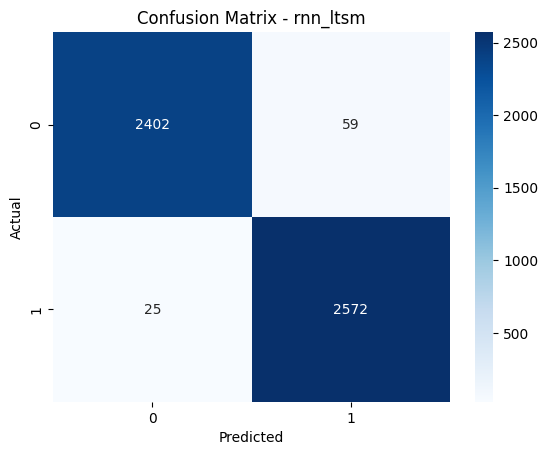

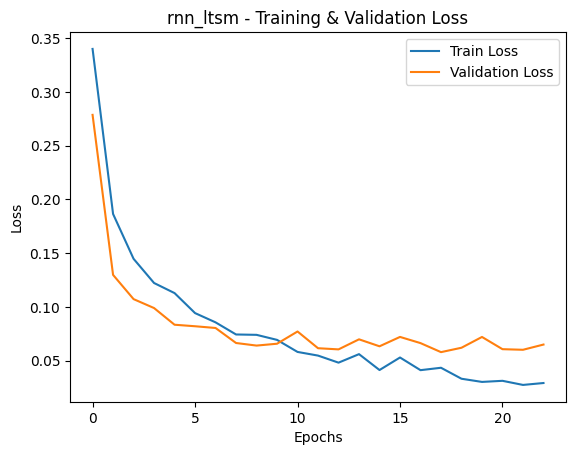

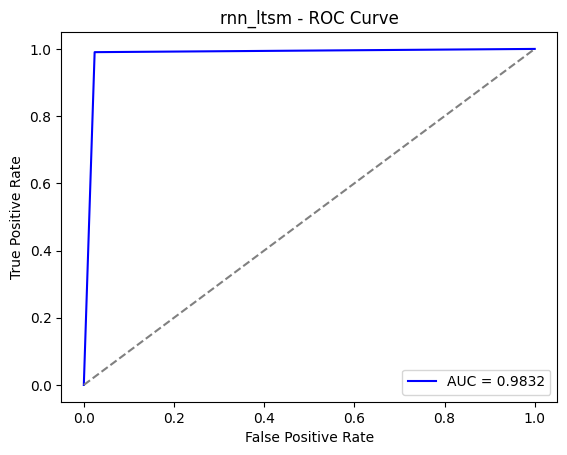

Epoch 1/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 63s 85ms/step - accuracy: 0.9910 - loss: 0.0278 - val_accuracy: 0.9820 - val_loss: 0.0728
Epoch 2/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 82s 84ms/step - accuracy: 0.9912 - loss: 0.0276 - val_accuracy: 0.9830 - val_loss: 0.0574
Epoch 3/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 85s 88ms/step - accuracy: 0.9921 - loss: 0.0250 - val_accuracy: 0.9818 - val_loss: 0.0761
Epoch 4/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 79s 84ms/step - accuracy: 0.9906 - loss: 0.0286 - val_accuracy: 0.9794 - val_loss: 0.0738
Epoch 5/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 83s 86ms/step - accuracy: 0.9926 - loss: 0.0197 - val_accuracy: 0.9828 - val_loss: 0.0686
Epoch 6/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 63s 85ms/step - accuracy: 0.9926 - loss: 0.0221 - val_accuracy: 0.9858 - val_loss: 0.0622
Epoch 7/50
738/738 ━━━━━━━━━━━━━━━━━━━━ 82s 85ms/step - accuracy: 0.9940 - loss: 0.0216 - val_accuracy: 0.9842 - val_loss: 0.0612
159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step
test_l

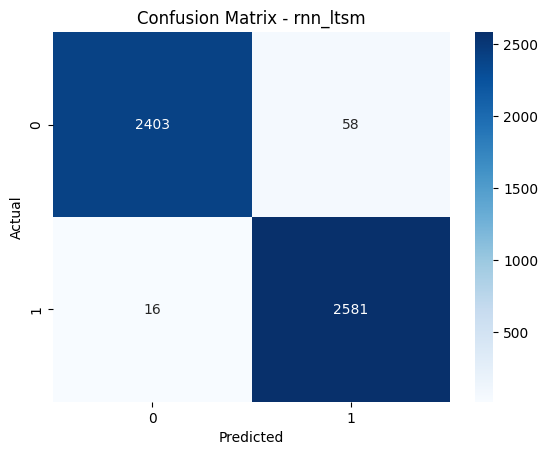

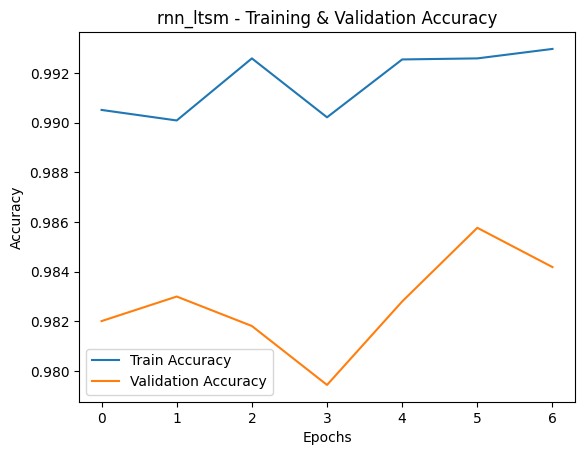

Epoch 1/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 40s 108ms/step - accuracy: 0.9929 - loss: 0.0210 - val_accuracy: 0.9842 - val_loss: 0.0579
Epoch 2/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 38s 101ms/step - accuracy: 0.9918 - loss: 0.0237 - val_accuracy: 0.9838 - val_loss: 0.0596
Epoch 3/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 37s 102ms/step - accuracy: 0.9931 - loss: 0.0222 - val_accuracy: 0.9850 - val_loss: 0.0610
Epoch 4/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 41s 101ms/step - accuracy: 0.9925 - loss: 0.0248 - val_accuracy: 0.9846 - val_loss: 0.0701
Epoch 5/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 38s 102ms/step - accuracy: 0.9908 - loss: 0.0281 - val_accuracy: 0.9816 - val_loss: 0.0672
Epoch 6/50
369/369 ━━━━━━━━━━━━━━━━━━━━ 38s 102ms/step - accuracy: 0.9933 - loss: 0.0198 - val_accuracy: 0.9818 - val_loss: 0.0742
159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step
159/159 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step
test_loss: 0.04587937891483307
test_accuracy: 0.9851720333099365
precision: 0.985
recall: 0.9861378513669619
f1_score: 0.985568597

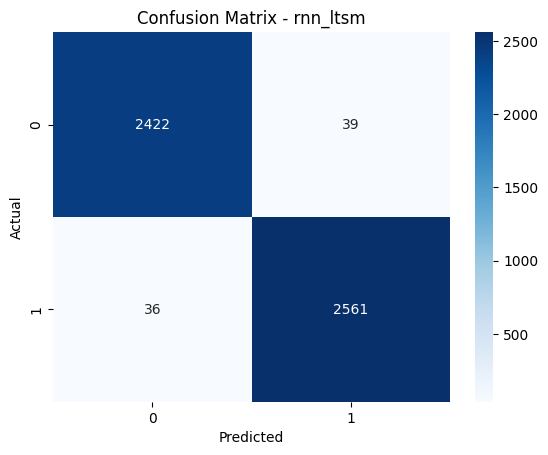

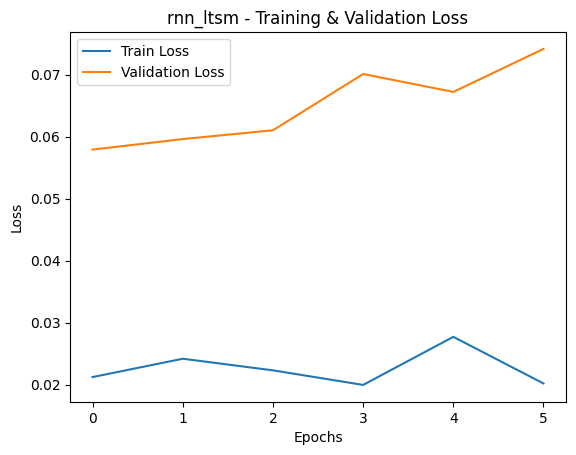

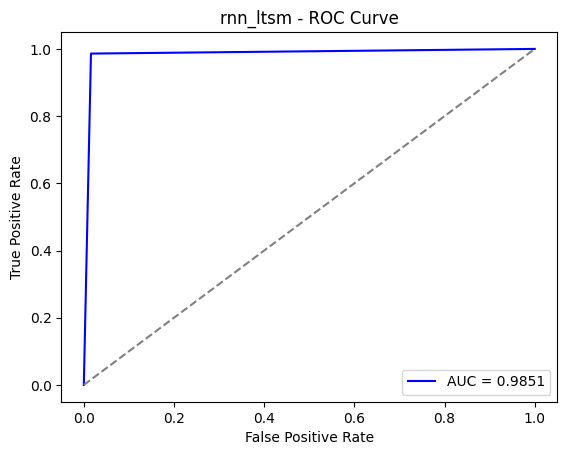

In [ ]:
# CNN + LTSM Model Training
for lr in LEARNING_RATES:
  rnn_ltsm_model =  build_rnn_lstm(vocab_size=len(word_index) + 1,
                          embedding_matrix=embedding_matrix, learning_rate=lr)
  model_name = "rnn_ltsm"
  train_and_evaluate(rnn_ltsm_model, model_name, lr,
                     X_train_padded, y_train, X_val_padded, y_val,
                     X_test_padded, y_test)